In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
# import scienceplots

# # plt.style.use('science')
# plt.style.use(['science','ieee'])

from numbers import Number
from typing import Optional, Any
from numpy.typing import ArrayLike

from functools import reduce

In [2]:
def _df_colors(val: Any):
    '''Функция для более выделяющихся цветов в датафреймах'''
    
    if isinstance(val, bool) and val is False:
        color = "red"
    elif isinstance(val, bool) and val is True:
        color = "limegreen"
    elif isinstance(val, Number):
        # color = "gold"
        color = "mediumspringgreen"
    else:
        color = "cornflowerblue"
    return "color: %s" % color

In [3]:
def cols2drop(corr_df, threshold=0.9) -> list[str]:
    '''Функия для определения слишком коррелирующих признаков'''
    corr_df = corr_df.abs()
    mask = np.triu(np.ones_like(corr_df, dtype=bool))
    tri_corr = corr_df.mask(mask)
    to_drop = [c for c in tri_corr.columns if any(tri_corr[c] > threshold)]
    return to_drop, mask

In [4]:
emo2num = {'С': 1,
           'О': 2,
           'Н': 3,
           'Ж': 4,
           'У': 5,
           'Р': 6,
           'Г': 7,
           'Б': 8,
           'З': 9,
           'В': 10}

num2emo = {val: key for key, val in emo2num.items()}

letter2emo = {
"Г": "грусть",
"З": "злость",
"Р": "радость",
"У": "удивление",
"В": "волнение",
"Ж": "раздражение",
"Н": "недовольство",
"О": "обида",
"Б": "обречённость",
"С": "страх"
}

# ML

In [5]:
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

In [6]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, roc_auc_score, roc_curve, RocCurveDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay#, multilabel_confusion_matrix
from sklearn.inspection import permutation_importance

In [7]:
std_scaler = StandardScaler()

In [8]:
def print_metrics(y_preds: ArrayLike, 
                  y: ArrayLike, 
                  y_probs: Optional[ArrayLike] = None
) -> None:
    print(f'MSE: {mean_squared_error(y_preds, y)}')
    print(f"Accuracy: {accuracy_score(y_preds, y)}")
    print(f"F-score: {f1_score(y, y_preds, average='weighted')}")
    if y_probs is not None: 
        print(f"ROC-AUC: {roc_auc_score(y, y_probs, multi_class='ovr')}")

In [9]:
def show_conf_matrx(y_real: ArrayLike, y_preds: ArrayLike, classes: ArrayLike, title: str="") -> None:
    fig, ax = plt.subplots(figsize=(20, 20))
    ax.set_title(title)
    cm_rfc = confusion_matrix(y_real, y_preds)
    disp_rfc = ConfusionMatrixDisplay(cm_rfc, 
                                      display_labels=[letter2emo[num2emo[klas]] for klas in classes])
    disp_rfc.plot(include_values=True, cmap="viridis", ax=ax, colorbar=True)

In [10]:
def show_roc_curves(y_train: ArrayLike, y_test: ArrayLike, y_score: ArrayLike, classes: ArrayLike) -> None:
    label_binarizer = LabelBinarizer().fit(y_train)
    y_onehot_test = label_binarizer.transform(y_test)

    fig, axs = plt.subplots(ncols=2,
                            nrows=2, 
                            figsize=(15, 10))
    for class_of_interest, axis in zip(classes, axs.flatten()):
        class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
        display = RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            y_score[:, class_id],
            name=f"{letter2emo[num2emo[class_of_interest]]} vs the rest",
            color="darkorange",
            plot_chance_level=True,
            ax=axis
        )
        _ = display.ax_.set(
            xlabel="",
            ylabel="",
            # title="One-vs-Rest ROC curves",
        )

In [50]:
def show_feature_importances(importances: ArrayLike, feature_names: ArrayLike, title: str, size=(6,6)) -> None:
    importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    sorted_importance = importances_df.sort_values(by='Importance', ascending=False)
    sorted_importance = sorted_importance[sorted_importance != 0]
    # fig, ax = plt.subplots(figsize=(10,6))
    plt.figure(figsize=size)
    plt.barh(sorted_importance['Feature'][:10], sorted_importance['Importance'][:10])
    plt.title(title)

## Dataset

In [12]:
# собираем признаки, полученные в другом ноутбуке в большую признаковую матрицу
basic_metrics_DF = pd.read_csv("basic_metrics_DF.csv", index_col=0)
pos_DF = pd.read_csv("pos_DF.csv", index_col=0)
Ngrams_DF = pd.read_csv("Ngrams_DF.csv", index_col=0)
gramm_DF = pd.read_csv("gramm_DF.csv", index_col=0)
emotion_DF = pd.read_csv("emotion_DF.csv", index_col=0)
syntax_DF = pd.read_csv("syntax_DF.csv", index_col=0)
zipf_DF = pd.read_csv("zipf_DF.csv", index_col=0)

In [13]:
data_frames = [basic_metrics_DF, pos_DF, Ngrams_DF, gramm_DF, emotion_DF, syntax_DF, zipf_DF]

In [14]:
wholeDF = reduce(lambda left,right: pd.merge(left, right, how='outer'), data_frames)
wholeDF.head().style.map(_df_colors)

,IDs,Primary Emotion,Emotion Class,V_lemma,syl,word_long,word_long_pr,ASW,ACW,lemma_long,lemma_long_pr,TTR_lemma,YuleI_word,YuleK_lemma,YuleI_lemma,Func_word_pr,Verb_pr,Noun_pr,Adj_pr,Pron_pr,Autosem_pr,Nouns_pr,NVR,Cconj_pr,Sconj_pr,Adjs_pr,Prtf_pr,Prts_pr,Npro_pr,Pred_p,Grnd_pr,Infn_pr,Numr_pr,Prcl_pr,Prep_pr,Comp_pr,Pos_ngrams_1_pr,Pos_ngrams_2_pr,Pos_ngrams_3_pr,Pos_ngrams_4_pr,Pos_ngrams_5_pr,Pos_ngrams_6_pr,Pos_ngrams_7_pr,Pos_ngrams_8_pr,Pos_ngrams_9_pr,Pos_ngrams_10_pr,Pos_ngrams_11_pr,Pos_ngrams_12_pr,Dyn_Stat,Gen_pr,Ablt_pr,Adjf_pr,Neut_pr,Inan_pr,1P_pr,3P_pr,Pres_pr,Futr_pr,Past_pr,Impf_pr,Perf_pr,Pssv_prtf_pr,Pssv_prts_pr,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,Acl_pr,Acl:relcl_pr,Advcl_pr,Advmod_pr,Amod_pr,Appos_pr,Aux:pass_pr,Ccomp_pr,Compound_pr,Conj_pr,Cop_pr,Csubj_pr,Csubj:pass_pr,Discourse_pr,Mark_pr,Nsubj_pr,Nsubj:pass_pr,Nummod_pr,Orphan_pr,Parataxis_pr,Xcomp_pr,0,1,2,3,4,5,6,7,8
0,0107635181_00__00-channel-0-number-004_18310,С,1,6,11,0,0.000000,1.833333,4.500000,0,0.000000,1.000000,0.000000,0.000000,0.000000,0.166667,0.333333,0.333333,0.000000,0.166667,0.666667,0.333333,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.166667,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.166667,0.000000,0.333333,0.000000,0.333333,0.333333,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0,0,0,0,2,1,2,0,1
1,0107635181_00__00-channel-0-number-005_22100,С,1,10,22,2,0.200000,2.200000,4.900000,1,0.100000,0.909091,0.000000,0.000000,0.000000,0.090909,0.272727,0.090909,0.000000,0.363636,0.454545,0.090909,0.333333,0.090909,0.000000,0.000000,0.000000,0.000000,0.181818,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,0.090909,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.090909,0.000000,0.090909,0.090909,0.181818,0.181818,0.090909,0.000000,0.181818,0.090909,0.000000,0.000000,1,1,0,1,0,1,1,0,0,1,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,0,0,0,0,0,2,3,3,1
2,0107635181_00__00-channel-0-number-006_26690,С,1,11,17,0,0.000000,1.416667,3.583333,0,0.000000,0.916667,40.333333,247.933884,40.333333,0.416667,0.083333,0.166667,0.166667,0.083333,0.500000,0.333333,2.000000,0.000000,0.000000,0.000000,0.083333,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,0.083333,0.250000,0.083333,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.083333,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.083333,0.000000,0,0,1,1,0,2,0,0,0,0,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,0,0,0,0,0,4,3,2,3
3,0107636961_00__00-channel-0-number-009_34800,С,1,7,15,1,0.125000,1.875000,4.125000,0,0.000000,0.875000,16.333333,612.244898,16.333333,0.000000,0.375000,0.000000,0.000000,0.500000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.125000,0.000000,0.125000,0.000000,0.000000,0.000000,0.000000,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000,0.000000,0.125000,0.000000,0.125000,0.125000,0.125000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,True,0,0,0,1,1,1,2,2,0
4,0107638181_00__00-channel-0-number-018_59400,С,1,5,11,1,0.200000,2.200000,4.800000,1,0.200000,0.833333,0.000000,0.000000,0.000000,0.166667

In [15]:
wholeDF = wholeDF.drop_duplicates(subset=["IDs"])
wholeDF.shape

(3488, 103)

In [16]:
wholeDF.describe().style.map(_df_colors)

,Emotion Class,V_lemma,syl,word_long,word_long_pr,ASW,ACW,lemma_long,lemma_long_pr,TTR_lemma,YuleI_word,YuleK_lemma,YuleI_lemma,Func_word_pr,Verb_pr,Noun_pr,Adj_pr,Pron_pr,Autosem_pr,Nouns_pr,NVR,Cconj_pr,Sconj_pr,Adjs_pr,Prtf_pr,Prts_pr,Npro_pr,Pred_p,Grnd_pr,Infn_pr,Numr_pr,Prcl_pr,Prep_pr,Comp_pr,Pos_ngrams_1_pr,Pos_ngrams_2_pr,Pos_ngrams_3_pr,Pos_ngrams_4_pr,Pos_ngrams_5_pr,Pos_ngrams_6_pr,Pos_ngrams_7_pr,Pos_ngrams_8_pr,Pos_ngrams_9_pr,Pos_ngrams_10_pr,Pos_ngrams_11_pr,Pos_ngrams_12_pr,Dyn_Stat,Gen_pr,Ablt_pr,Adjf_pr,Neut_pr,Inan_pr,1P_pr,3P_pr,Pres_pr,Futr_pr,Past_pr,Impf_pr,Perf_pr,Pssv_prtf_pr,Pssv_prts_pr,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,0,1,2,3,4,5,6,7,8
count,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000
mean,7.149656,7.440654,15.968177,0.892202,0.118291,2.022099,4.734822,0.549312,0.073440,0.924175,6.389584,386.591902,7.292382,0.244975,0.194835,0.177532,0.043340,0.192520,0.550294,0.220872,0.743387,0.040342,0.019452,0.004120,0.001497,0.002135,0.132974,0.017958,0.000292,0.030730,0.032467,0.109055,0.084054,0.002304,0.015264,0.024645,0.014569,0.032238,0.020746,0.003600,0.008619,0.000061,0.000036,0.000517,0.000444,0.000210,3.360910,0.060121,0.009236,0.067282,0.016871,0.132878,0.027973,0.041813,0.068108,0.014252,0.051769,0.089970,0.053982,0.000854,0.002135,0.065940,0.079415,0.052752,0.120126,0.026376,0.290711,0.438933,0.118119,0.046445,0.319667,0.000573,0.016628,0.078842,0.296732,0.573681,1.608658,2.594037,2.269495,0.331422
std,3.189632,2.802745,6.537037,0.953383,0.133071,0.452752,1.132358,0.752306,0.105889,0.102883,14.185738,977.392723,14.034625,0.148633,0.132357,0.148041,0.085866,0.140176,0.194656,0.179115,0.882153,0.071101,0.050775,0.026081,0.016542,0.018630,0.120325,0.053362,0.005852,0.064681,0.103828,0.123662,0.098098,0.017573,0.047260,0.056724,0.044723,0.068224,0.068659,0.028991,0.039828,0.002531,0.002117,0.009088,0.008875,0.006411,6.727661,0.100958,0.040576,0.101144,0.052759,0.129551,0.061126,0.080940,0.094243,0.050571,0.086742,0.101038,0.089722,0.011014,0.018630,0.266058,0.287889,0.229895,0.351435,0.175641,0.554777,0.669931,0.357369,0.227501,0.574422,0.023942,0.134452,0.292001,0.542404,0.756781,1.264641,1.824785,1.731858,0.619647
min,1.000000,2.000000,2.000000,0.000000,0.000000,0.500000,2.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,5.000000,11.000000,0.000000,0.000000,1.714286,4.000000,0.000000,0.000000,0.857143,0.000000,0.000000,0.000000,0.142857,0.1111

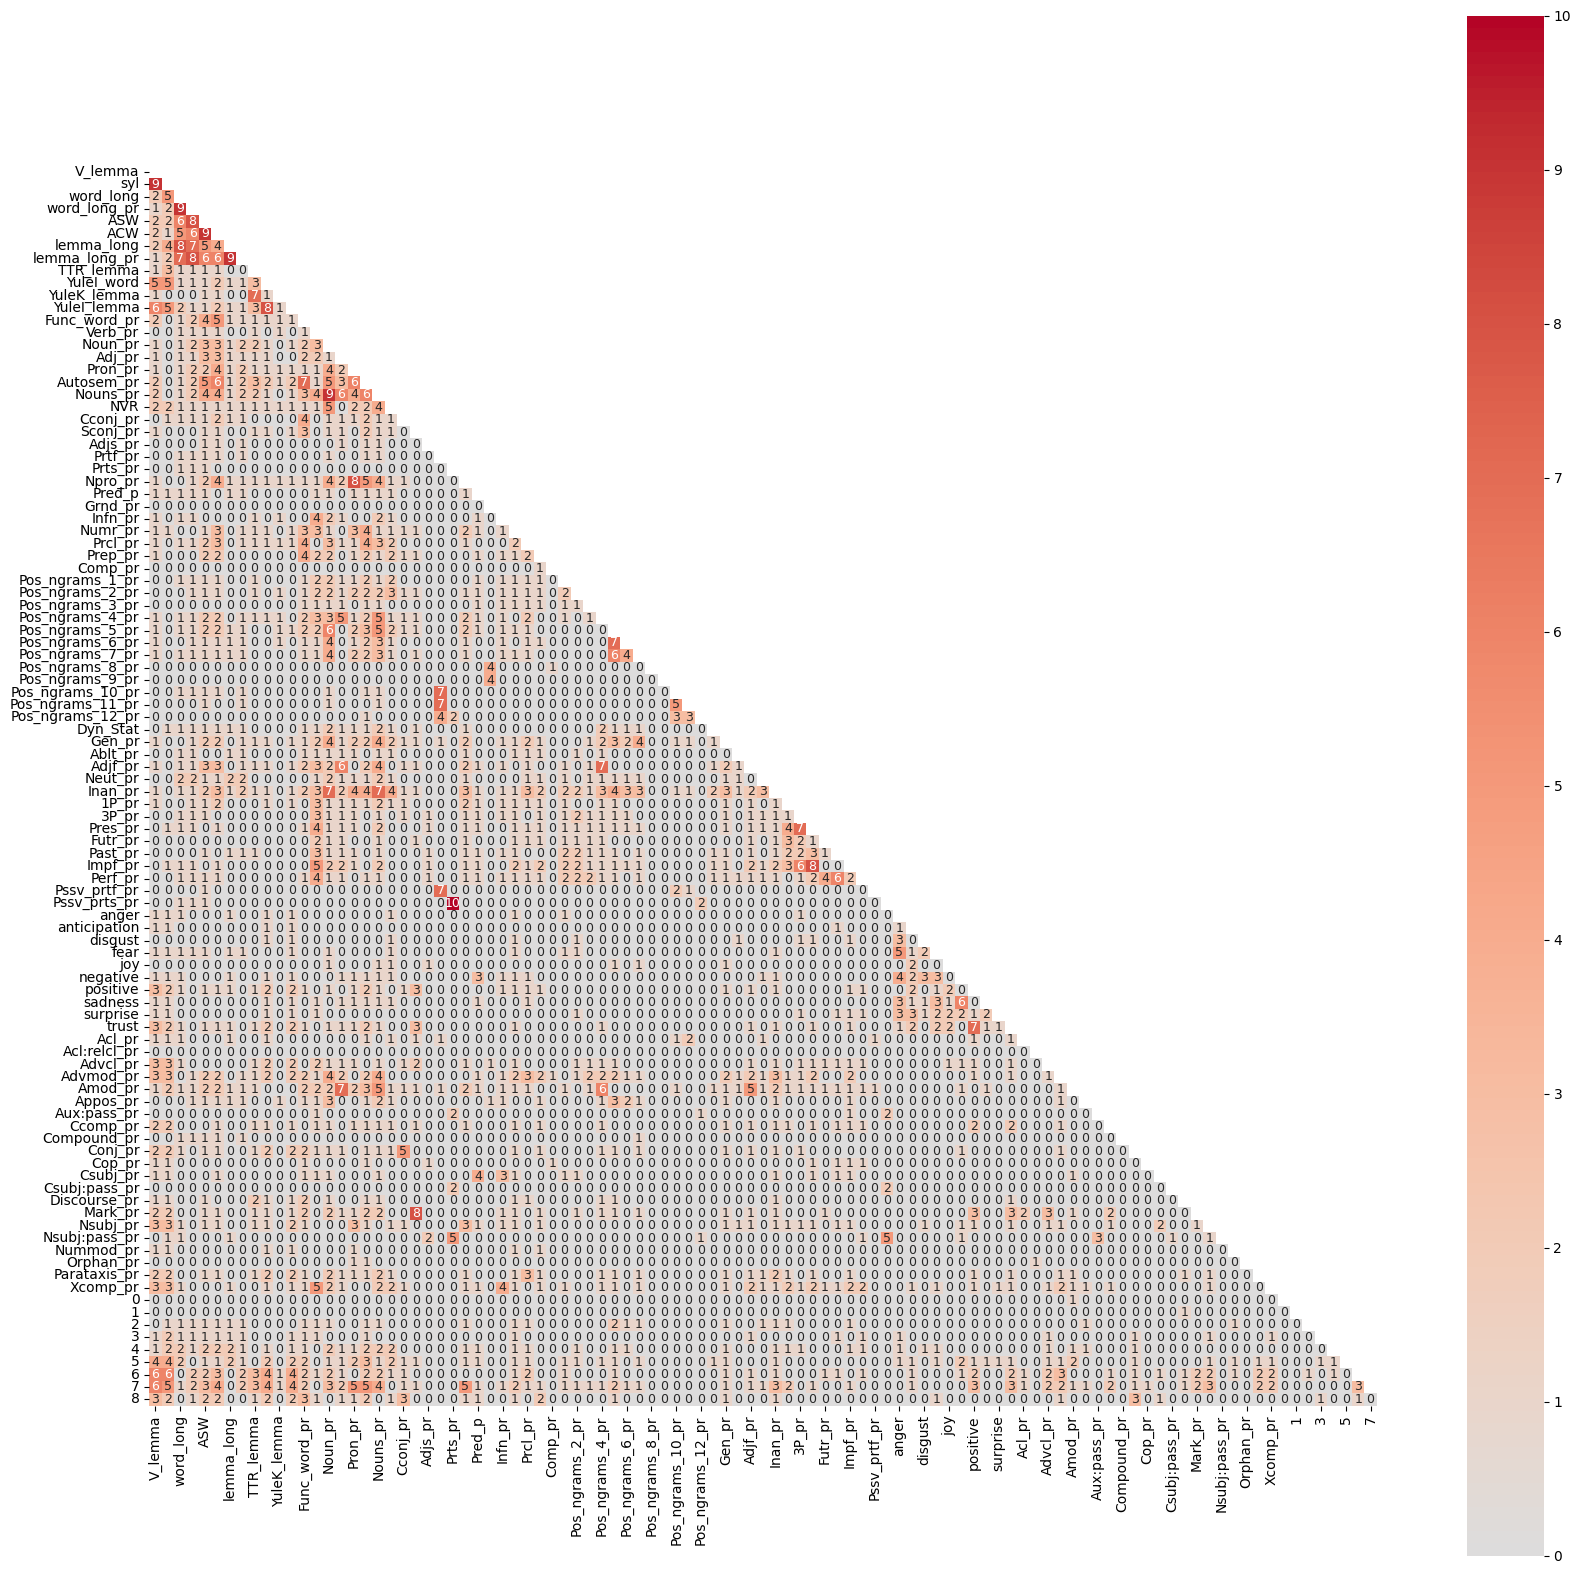

In [17]:
corr_whole = wholeDF[wholeDF.columns[3:]].corr(numeric_only=True)

drop_whole, mask_whole = cols2drop(corr_whole)

corr_whole = (corr_whole.abs() * 10).round()

plt.figure(figsize=(20, 20))
sns.heatmap(
    corr_whole,
    mask=mask_whole,
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=0.001,
    annot=True,
    annot_kws={"size": 9},
    cbar_kws={"ticks": [i for i in range(10 + 1)]},
)
plt.savefig(
    r"C:\Users\Ivan\Desktop\AI\0_Dissertation\CorrHeatmapWhole.png", bbox_inches="tight"
)

In [18]:
drop_whole

['Prts_pr']

In [19]:
wholeDF = wholeDF.drop(drop_whole, axis=1)

In [20]:
wholeDF[wholeDF.columns[3:]] = std_scaler.fit_transform(wholeDF[wholeDF.columns[3:]])
wholeDF.head().style.map(_df_colors)

,IDs,Primary Emotion,Emotion Class,V_lemma,syl,word_long,word_long_pr,ASW,ACW,lemma_long,lemma_long_pr,TTR_lemma,YuleI_word,YuleK_lemma,YuleI_lemma,Func_word_pr,Verb_pr,Noun_pr,Adj_pr,Pron_pr,Autosem_pr,Nouns_pr,NVR,Cconj_pr,Sconj_pr,Adjs_pr,Prtf_pr,Npro_pr,Pred_p,Grnd_pr,Infn_pr,Numr_pr,Prcl_pr,Prep_pr,Comp_pr,Pos_ngrams_1_pr,Pos_ngrams_2_pr,Pos_ngrams_3_pr,Pos_ngrams_4_pr,Pos_ngrams_5_pr,Pos_ngrams_6_pr,Pos_ngrams_7_pr,Pos_ngrams_8_pr,Pos_ngrams_9_pr,Pos_ngrams_10_pr,Pos_ngrams_11_pr,Pos_ngrams_12_pr,Dyn_Stat,Gen_pr,Ablt_pr,Adjf_pr,Neut_pr,Inan_pr,1P_pr,3P_pr,Pres_pr,Futr_pr,Past_pr,Impf_pr,Perf_pr,Pssv_prtf_pr,Pssv_prts_pr,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,Acl_pr,Acl:relcl_pr,Advcl_pr,Advmod_pr,Amod_pr,Appos_pr,Aux:pass_pr,Ccomp_pr,Compound_pr,Conj_pr,Cop_pr,Csubj_pr,Csubj:pass_pr,Discourse_pr,Mark_pr,Nsubj_pr,Nsubj:pass_pr,Nummod_pr,Orphan_pr,Parataxis_pr,Xcomp_pr,0,1,2,3,4,5,6,7,8
0,0107635181_00__00-channel-0-number-004_18310,С,1,-0.514089,-0.760113,-0.935962,-0.889061,-0.416990,-0.207404,-0.730275,-0.693660,0.737110,-0.450488,-0.395591,-0.519674,-0.526931,1.046548,1.052569,-0.504816,-0.184464,0.597924,0.627962,0.290936,-0.567475,-0.383154,-0.158000,-0.090520,-1.105283,-0.336580,-0.049948,-0.475165,-0.312745,-0.882008,0.842261,-0.131105,-0.323024,2.504106,-0.325820,1.970682,-0.302208,-0.124194,-0.216431,-0.023919,-0.016935,-0.056890,-0.049991,-0.032819,-0.350976,-0.595587,-0.227658,0.982744,-0.319830,1.547532,-0.457701,3.602193,2.814668,-0.281872,-0.596896,2.408979,-0.601743,-0.077563,-0.114610,-0.247878,-0.275893,-0.229496,-0.341865,-0.150192,-0.524090,-0.655286,-0.330572,-0.204182,-0.556583,-0.134525,-0.058756,2.543413,-1.430485,-0.450748,-0.176175,-0.058756,-0.206007,-0.016935,-0.436399,-0.194387,-0.262593,-0.033884,-0.270001,-0.410022,-1.671954,-0.134525,-0.115604,-0.050862,-0.426112,-0.574260,-0.023953,-0.123694,-0.270043,-0.547146,1.884989,-0.481358,-0.325585,-1.310627,1.079121
1,0107635181_00__00-channel-0-number-005_22100,С,1,0.913288,0.922847,1.162133,0.614111,0.392989,0.145892,0.599161,0.250862,-0.146634,-0.450488,-0.395591,-0.519674,-1.036698,0.588585,-0.585209,-0.504816,1.220899,-0.491954,-0.725691,-0.464899,0.711299,-0.383154,-0.158000,-0.090520,0.405989,-0.336580,-0.049948,-0.475165,-0.312745,-0.882008,-0.856963,-0.131105,-0.323024,-0.434527,1.707207,0.860096,-0.302208,-0.124194,-0.216431,-0.023919,-0.016935,-0.056890,-0.049991,-0.032819,-0.350976,-0.595587,-0.227658,0.233632,-0.319830,-0.324001,1.029751,1.729988,1.206735,1.516056,-0.596896,0.909176,0.411637,-0.077563,-0.114610,3.511241,3.198171,-0.229496,2.504020,-0.150192,1.278696,0.837619,-0.330572,-0.204182,1.184548,-0.134525,-0.058756,-0.393172,0.699063,-0.450748,-0.176175,-0.058756,-0.206007,-0.016935,-0.436399,-0.194387,-0.262593,-0.033884,-0.270001,-0.410022,0.598103,-0.134525,-0.115604,-0.050862,-0.426112,1.741370,-0.023953,-0.123694,-0.270043,-0.547146,-0.758163,0.309493,0.222504,0.421864,1.079121
2,0107635181_00__00-channel-0-number-006_26690,С,1,1.270132,0.157865,-0.935962,-0.889061,-1.337421,-1.017041,-0.730275,-0.693660,-0.072988,2.393151,-0.141886,2.354583,1.155302,-0.842550,-0.073404,1.436471,-0.779040,-0.258409,0.627962,1.424689,-0.567475,-0.383154,-0.158000,4.947925,-0.412617,-0.336580,-0.049948,-0.475165,-0.312745,-0.208030,1.691873,4.611830,-0.323024,-0.434527,-0.325820,0.749038,-0.302208,-0.124194,-0.216431,-0.023919,-0.016935,-0.056890,-0.049991,-0.032819,-0.499638,-0.595587,-0.227658,0.158721,-0.319830,0.260853,-0.457701,-0.516658,-0.722784,-0.281872,-0.596896,-0.890587,-0.601743,7.489911,-0.114610,-0.247878,-0.275893,4.120944,2.504020,-0.150192,3.081481,-0.655286,-0.330572,-0.204182,-0.556583,-0.134525,-0.058756,-0.393172,0.699063,2.218536,-0.176175,-0.058756,-0.206007,-0.016935,-0.436399,-0.194387,-0.262593,-0.033884,-0.270001,-0.410022,0.598103,-0.134525,-0.115604,-0.050862,2.346798,-0.574260,-0.023953,-0.123694,-0.270043,-0.547146,-0.758163,1.891196,0.222504,-0.155633,4.307229
3,010763696

•	Эмоции:
```python
o	Г: грусть, печаль, горе, разочарование, огорчение
o	З: злость, гнев, досада
o	Р: радость, восторг, веселье, смех
o	У: удивление, изумление, непонимание, растерянность, недоумение, сомнение
o	В: волнение, возбуждение, беспокойство, тревога
o	Ж: раздражение, нетерпеливость
o	Н: недовольство, возмущение
o	О: обида, расстройство
o	Б: обречённость, усталость, безысходность, слабость
o	С: страх, испуг, паника, отчаяние
```

```py
{'С': 36,
 'О': 50,
 'Н': 848,
 'Ж': 292,
 'У': 211,
 'Р': 13,
 'Г': 70,
 'Б': 117,
 'З': 177,
 'В': 1758}
```
Г + Б + О

В + С

Р + У

З + Н + Ж

In [21]:
classes_merge_table = {1: 10,
                       2: 7,
                       3: 3,
                       4: 3,
                       5: 5,
                       6: 5,
                       7: 7,
                       8: 7,
                       9: 3,
                       10: 10}

In [22]:
# попробуем дропнуть радость, её слишком мало
# print(wholeDF.shape)
# wholeDF.drop(wholeDF[wholeDF["Primary Emotion"] == "Р"].index, inplace=True)
# print(wholeDF.shape)

In [23]:
wholeDF = wholeDF.replace({"Emotion Class": classes_merge_table})
set(wholeDF["Emotion Class"])

{3, 5, 7, 10}

In [24]:
X_train, X_test, y_train, y_test = train_test_split(wholeDF[wholeDF.columns[3:]], 
                                                    wholeDF["Emotion Class"], 
                                                    test_size=0.1, # данных не так много, берём максимум на обучение 
                                                    shuffle=True, 
                                                    random_state=42)

In [25]:
from collections import Counter

In [26]:
Counter(wholeDF["Emotion Class"])

Counter({10: 1750, 3: 1308, 7: 222, 5: 208})

## Decision Tree

In [27]:
from time import time

In [28]:
start = time()

dtc = DecisionTreeClassifier(random_state=42)
dtc.fit(X=X_train, y=y_train)

print(f"Fit duration: {time() - start:.3}s \n")

print("Test:")
print_metrics(dtc.predict(X_test), y_test, dtc.predict_proba(X_test))

print("\nTrain:")
print_metrics(dtc.predict(X_train), y_train, dtc.predict_proba(X_train))

Fit duration: 0.37s 

Test:
MSE: 18.441260744985673
Accuracy: 0.4699140401146132
F-score: 0.4686085346185981
ROC-AUC: 0.5460255303718614

Train:
MSE: 0.0
Accuracy: 1.0
F-score: 1.0
ROC-AUC: 1.0


In [29]:
for depth in [1, 2, 3, 4, 5, 6, 10, 15, 20, 50, 100, None]:
    dt = DecisionTreeClassifier(max_depth=depth, random_state=42)
    dt.fit(X_train, y_train)
    y_pred = dt.predict_proba(X_test)
    auc = roc_auc_score(y_test, y_pred, multi_class='ovr')
    print(f'{str(depth):>4} -> {auc:.3}')

   1 -> 0.501
   2 -> 0.537
   3 -> 0.513
   4 -> 0.509
   5 -> 0.488


   6 -> 0.495
  10 -> 0.51
  15 -> 0.523
  20 -> 0.517
  50 -> 0.546
 100 -> 0.546
None -> 0.546


Проведём гридсёрч для подбора лучших параметров модели

In [30]:
# parameters = {
#     "criterion": ['gini', 'entropy', 'log_loss'],
#     "max_depth": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, None],
#     "splitter": ['best', 'random'],
#     # "min_samples_split": [2, 2.5, 3],
#     # "min_samples_leaf": [1, 2, 2.5, 3], 
#     # "min_weight_fraction_leaf": [0.0, 0.1, 1.0, 1.5, 2],
#     "max_features": ["sqrt", "log2", None, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 1],
#     # "max_leaf_nodes": [None, 1, 2, 5],
#     "min_impurity_decrease": [0, 1, 2, 3],
#     "class_weight": [None, "balanced"],
#     # "ccp_alpha": [0, 1, 0.2, 2.5]
# }

In [31]:
# dec_tree = DecisionTreeClassifier(random_state=42)

Закомментил ячейки с гридсёрчем так как они долго выполняются, а результат я уже применил

In [32]:
# dt_grid = GridSearchCV(estimator=dec_tree, 
#                        param_grid=parameters,
#                        scoring=None,
#                        refit=True,
#                        verbose=4,
#                        pre_dispatch="2*n_jobs",
#                     #    error_score=...,
#                        return_train_score=False,
#                        cv=5,
#                        n_jobs=-1)
# dt_grid.fit(X_train, y_train)

In [33]:
# dt_grid.best_params_

In [34]:
dec_tree = DecisionTreeClassifier(criterion="entropy", 
                                  splitter="best", 
                                  max_depth = 5, # я не понимаю, почему не 3, если гридсёрч выдаёт его, но лучше результат с 5
                                  min_samples_split = 2, 
                                  min_samples_leaf = 1, 
                                  min_weight_fraction_leaf = 0, 
                                  max_features = 0.4, 
                                  random_state = 42, 
                                  max_leaf_nodes = None, 
                                  min_impurity_decrease = 0, 
                                  class_weight = None, 
                                  ccp_alpha = 0
)

In [35]:
dec_tree.fit(X=X_train, y=y_train)
print("Test:")
print_metrics(dec_tree.predict(X_test), y_test, dec_tree.predict_proba(X_test))
print("\nTrain:")
print_metrics(dec_tree.predict(X_train), y_train, dec_tree.predict_proba(X_train))

Test:
MSE: 20.363896848137536
Accuracy: 0.501432664756447
F-score: 0.4334072489373074
ROC-AUC: 0.5658533687890733

Train:
MSE: 17.871615164064988
Accuracy: 0.5508123606244026
F-score: 0.4793252967469574
ROC-AUC: 0.6621615724628082


Error in callback <function _draw_all_if_interactive at 0x00000202C8947CE0> (for post_execute):


KeyboardInterrupt: 

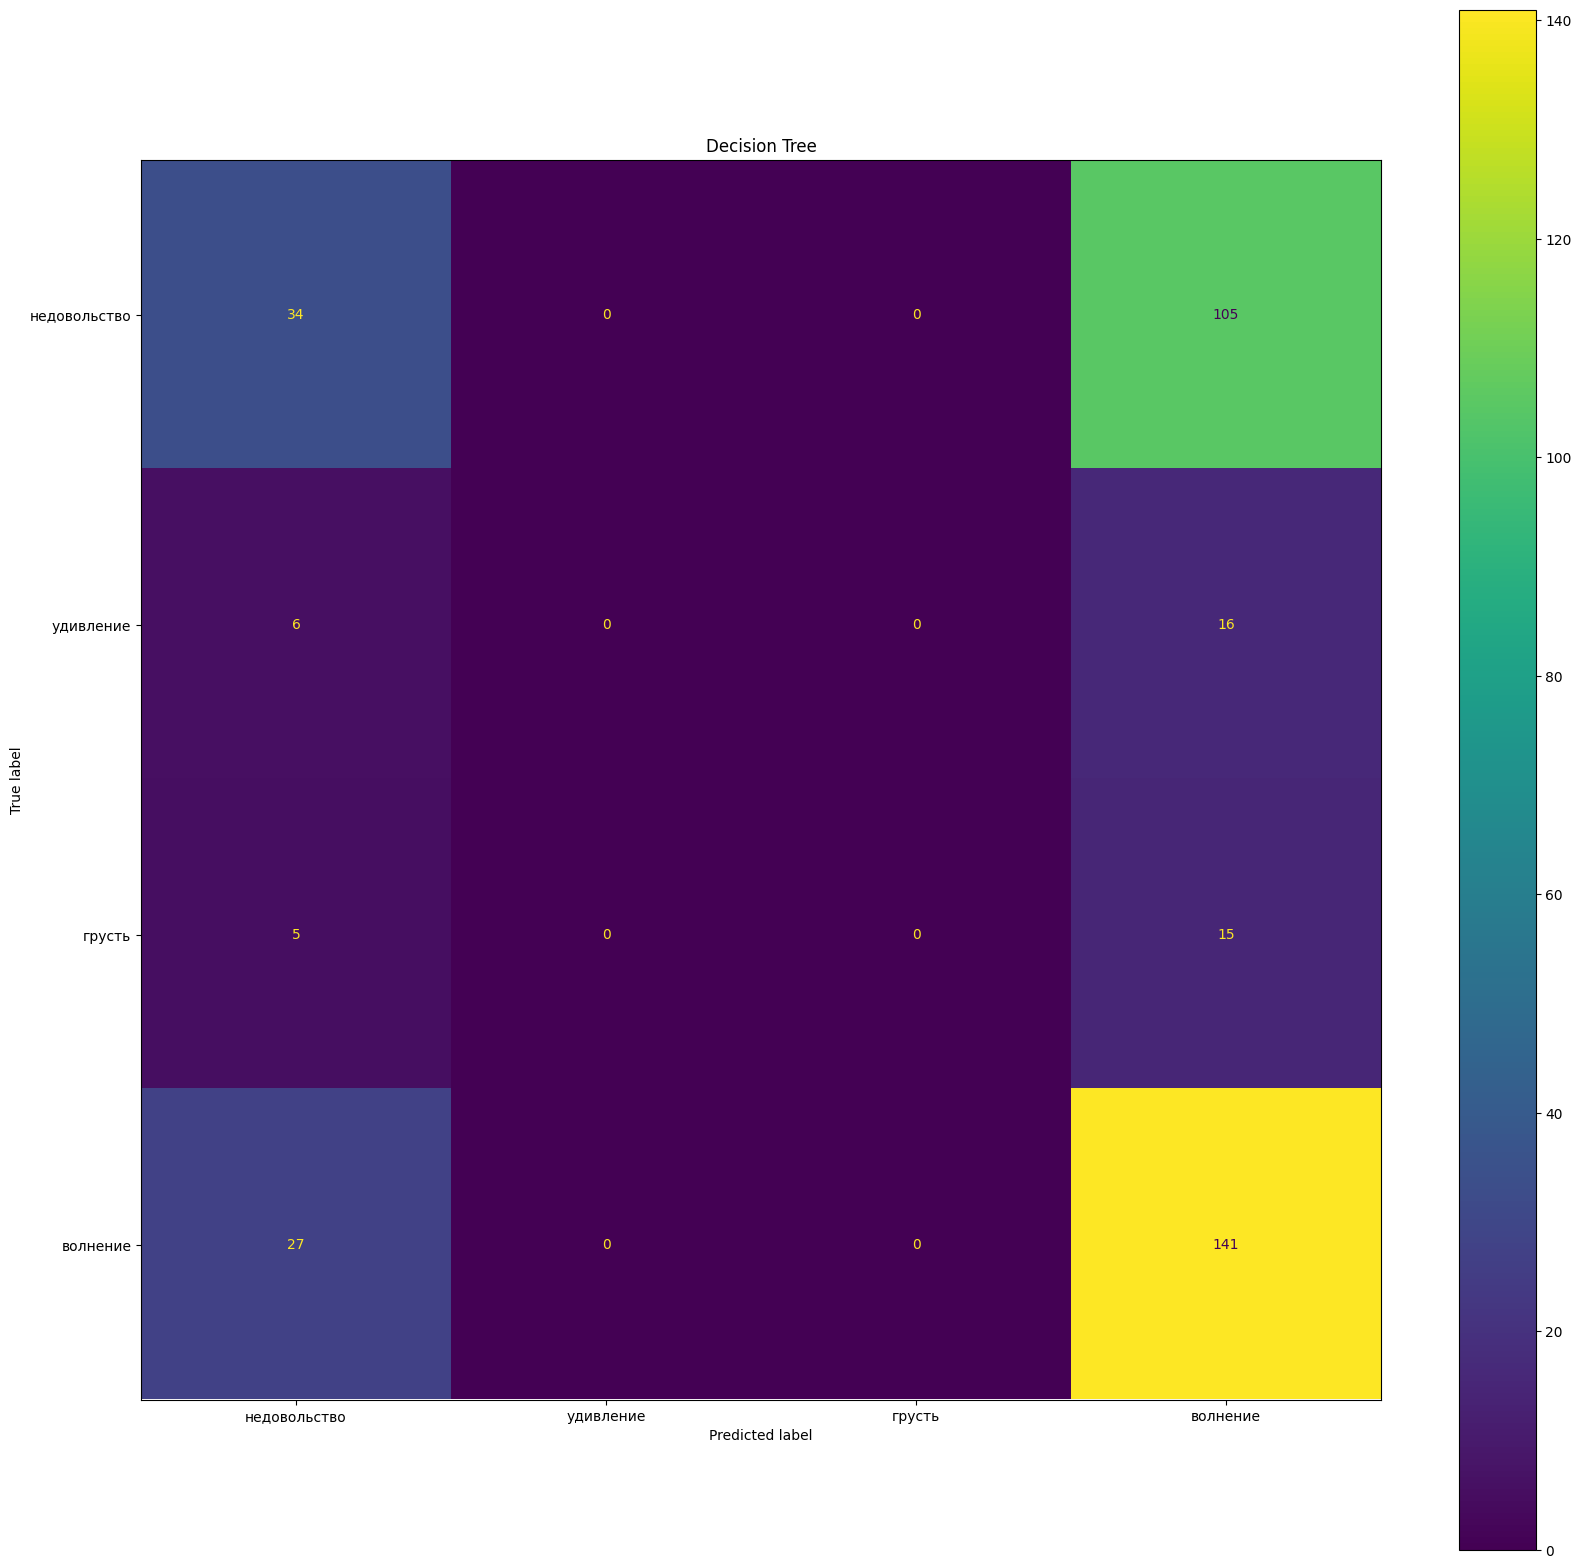

In [36]:
show_conf_matrx(y_test, dec_tree.predict(X_test), dec_tree.classes_, "Decision Tree")

In [ ]:
dec_tree.classes_

array([ 3,  5,  7, 10], dtype=int64)

In [ ]:
emo2num = {'С': 1,
           'О': 2,
           'Н': 3,
           'Ж': 4,
           'У': 5,
           'Р': 6,
           'Г': 7,
           'Б': 8,
           'З': 9,
           'В': 10}

num2emo = {val: key for key, val in emo2num.items()}

letter2emo = {
"Г": "грусть",
"З": "злость",
"Р": "радость",
"У": "удивление",
"В": "волнение",
"Ж": "раздражение",
"Н": "недовольство",
"О": "обида",
"Б": "обречённость",
"С": "страх"
}

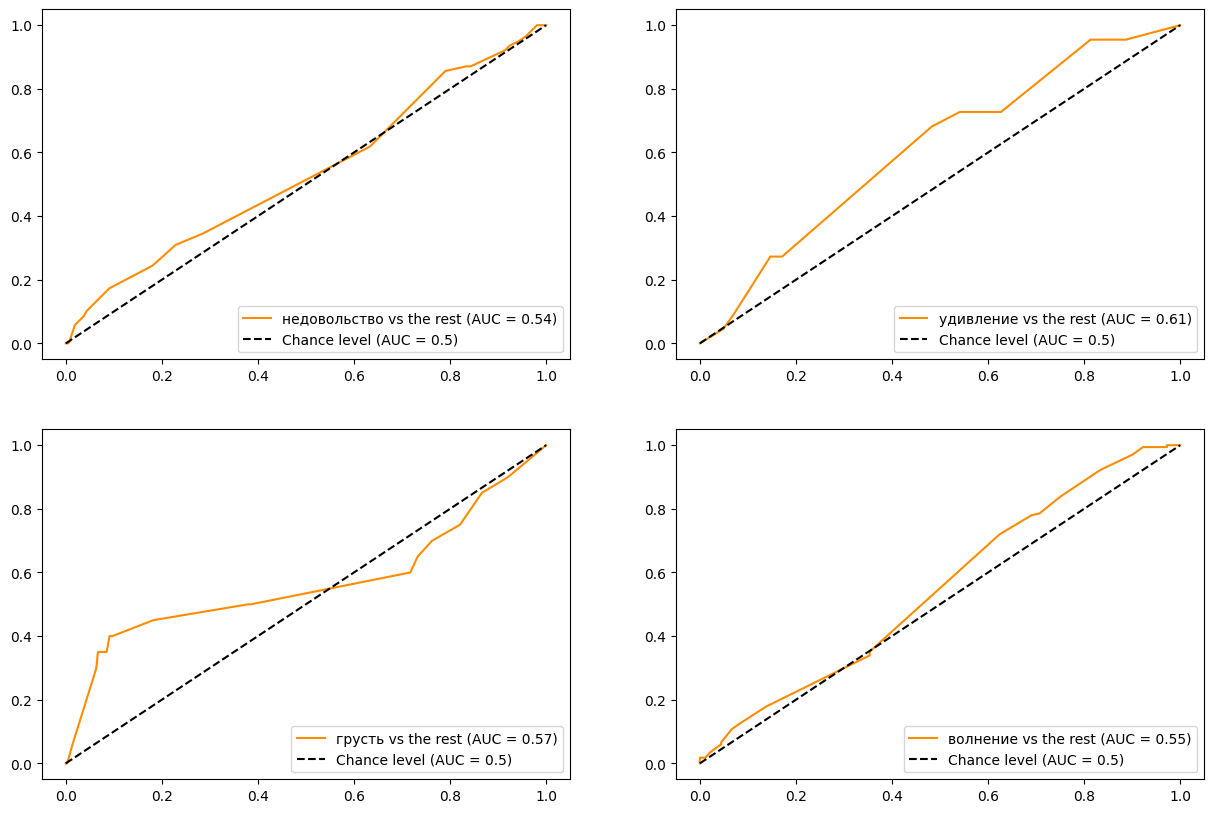

In [ ]:
show_roc_curves(y_train, y_test, dec_tree.predict_proba(X_test), classes=dec_tree.classes_)

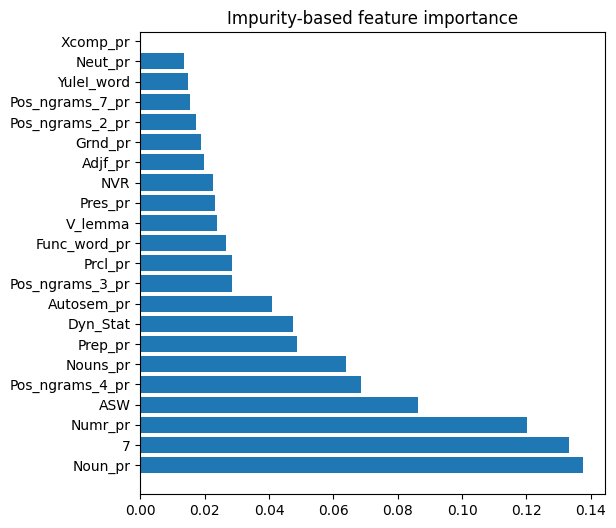

In [ ]:
show_feature_importances(dec_tree.feature_importances_, X_test.columns, "Impurity-based feature importance")

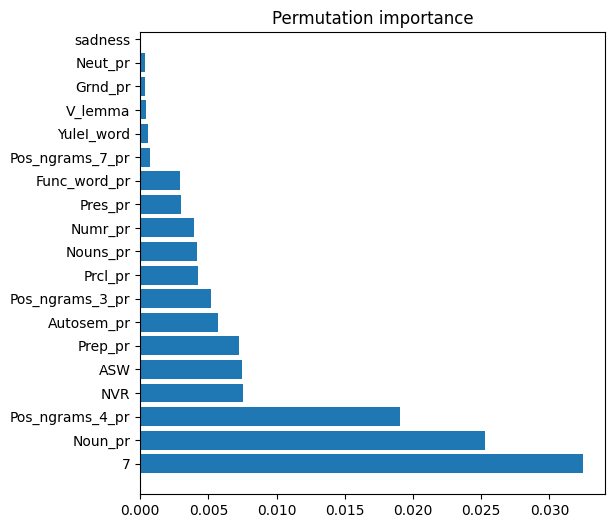

In [ ]:
perm_imp_dec_tree = permutation_importance(dec_tree, X_train, y_train, n_repeats=30, n_jobs=-1, random_state=42)
show_feature_importances(perm_imp_dec_tree.importances_mean, X_test.columns, "Permutation importance")

## Random Forest

In [ ]:
start = time()
rfc = RandomForestClassifier(n_estimators=1000,
                             criterion="gini",
                             max_depth=None, 
                             min_samples_split=2,
                             min_samples_leaf=1,
                             min_weight_fraction_leaf=0,
                             max_features="sqrt",
                             max_leaf_nodes=None,
                             min_impurity_decrease=0,
                             bootstrap=True,
                             oob_score=False,
                             n_jobs=-1,
                             random_state=42,
                             verbose=0,
                             warm_start=False,
                             class_weight=None,
                             ccp_alpha=0,
                             max_samples=None
)
rfc.fit(X=X_train, y=y_train)
print(f"Fit duration: {time() - start:.3}s \n")

print("Test:")
print_metrics(rfc.predict(X_test), y_test, rfc.predict_proba(X_test))
print("\nTrain:")
print_metrics(rfc.predict(X_train), y_train, rfc.predict_proba(X_train))

Fit duration: 7.02s 

Test:
MSE: 22.297994269340975
Accuracy: 0.4699140401146132
F-score: 0.4252095984562739
ROC-AUC: 0.6156888122779945

Train:
MSE: 0.0
Accuracy: 1.0
F-score: 1.0
ROC-AUC: 1.0


In [ ]:
# parameters = {
#     "n_estimators": [1000, 1500, 700],
#     "max_depth": [20, 25, 15],
# }

# rfc = RandomForestClassifier(n_jobs=-1,
#                              random_state=42,
#                              max_features="log2",
#                              criterion="gini")

# rfc_grid = GridSearchCV(estimator=rfc, 
#                        param_grid=parameters,
#                        scoring=None,
#                        refit=True,
#                        verbose=4,
#                        pre_dispatch="2*n_jobs",
#                     #    error_score=...,
#                        return_train_score=False,
#                        cv=5,
#                        n_jobs=-1)
# rfc_grid.fit(X_train, y_train)

# rfc_grid.best_params_

In [ ]:
rfc = RandomForestClassifier(max_depth=20, 
                             n_estimators=1000,
                             n_jobs=-1,
                             random_state=42,
                             max_features="log2",
                             criterion="gini")

rfc.fit(X=X_train, y=y_train)

print("Test:")
print_metrics(rfc.predict(X_test), y_test, rfc.predict_proba(X_test))
print("\nTrain:")
print_metrics(rfc.predict(X_train), y_train, rfc.predict_proba(X_train))

Test:
MSE: 22.197707736389685
Accuracy: 0.4699140401146132
F-score: 0.41993840748486305
ROC-AUC: 0.6074647359491272

Train:
MSE: 0.008601465434851864
Accuracy: 0.9990442816183498
F-score: 0.9990411592729932
ROC-AUC: 1.0


In [ ]:
# fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(30, 10))
# plt.subplots_adjust(hspace=0.5)
# fig.suptitle("Confusion matrices", fontsize=18, y=0.95)
# mcm_rfc = multilabel_confusion_matrix(y_test, rfc.predict(X_test), labels=rfc.classes_)

# for confusion_matrix, ax, klas in zip(mcm_rfc, axs.ravel(), rfc.classes_):
#     disp = ConfusionMatrixDisplay(confusion_matrix, display_labels=[letter2emo[num2emo[klas]], "other"])
#     disp.plot(include_values=True, cmap="viridis", ax=ax, xticks_rotation="vertical")

# plt.show()

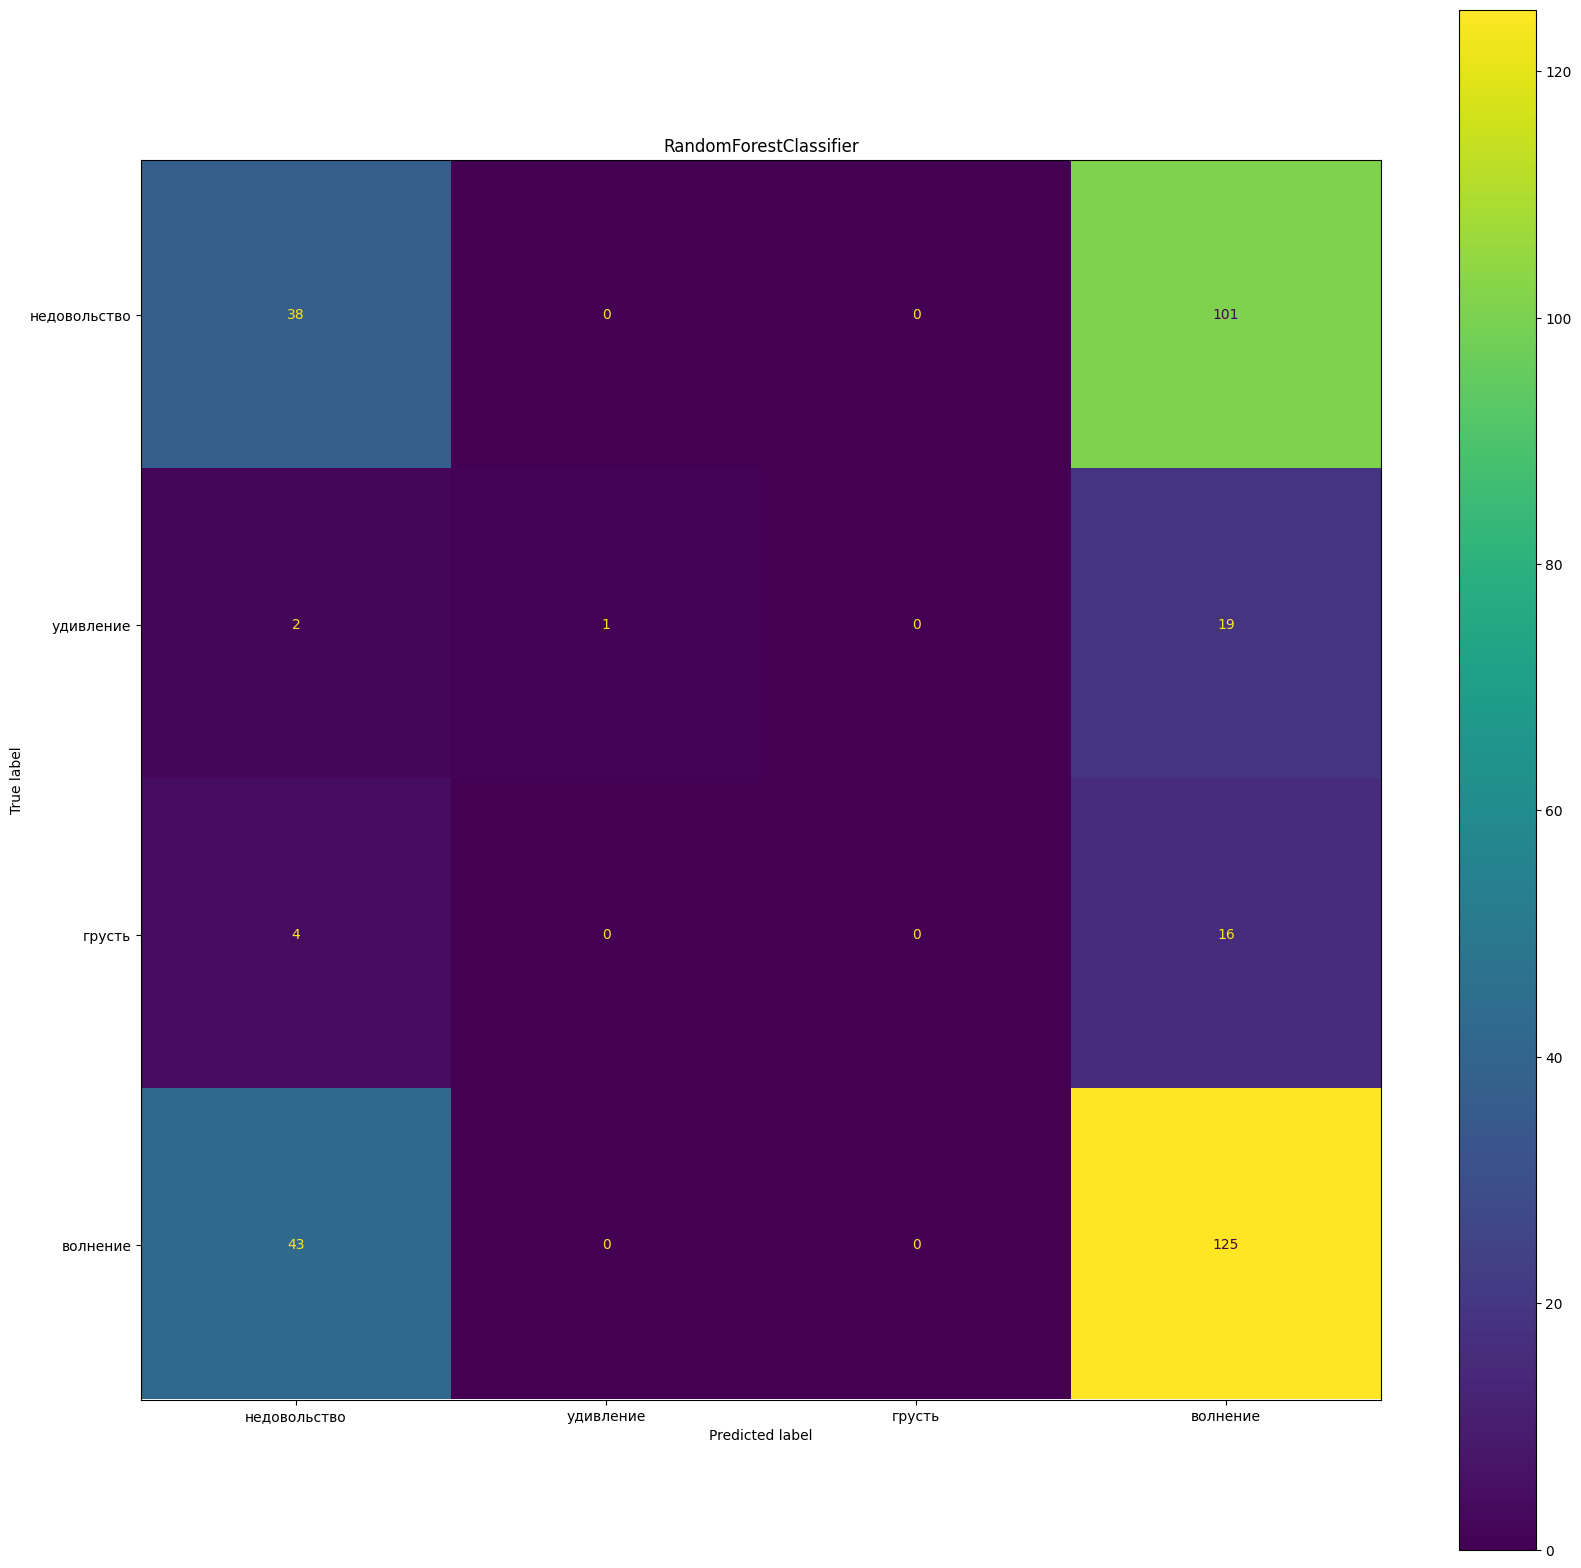

In [ ]:
show_conf_matrx(y_test, rfc.predict(X_test), rfc.classes_, "RandomForestClassifier")

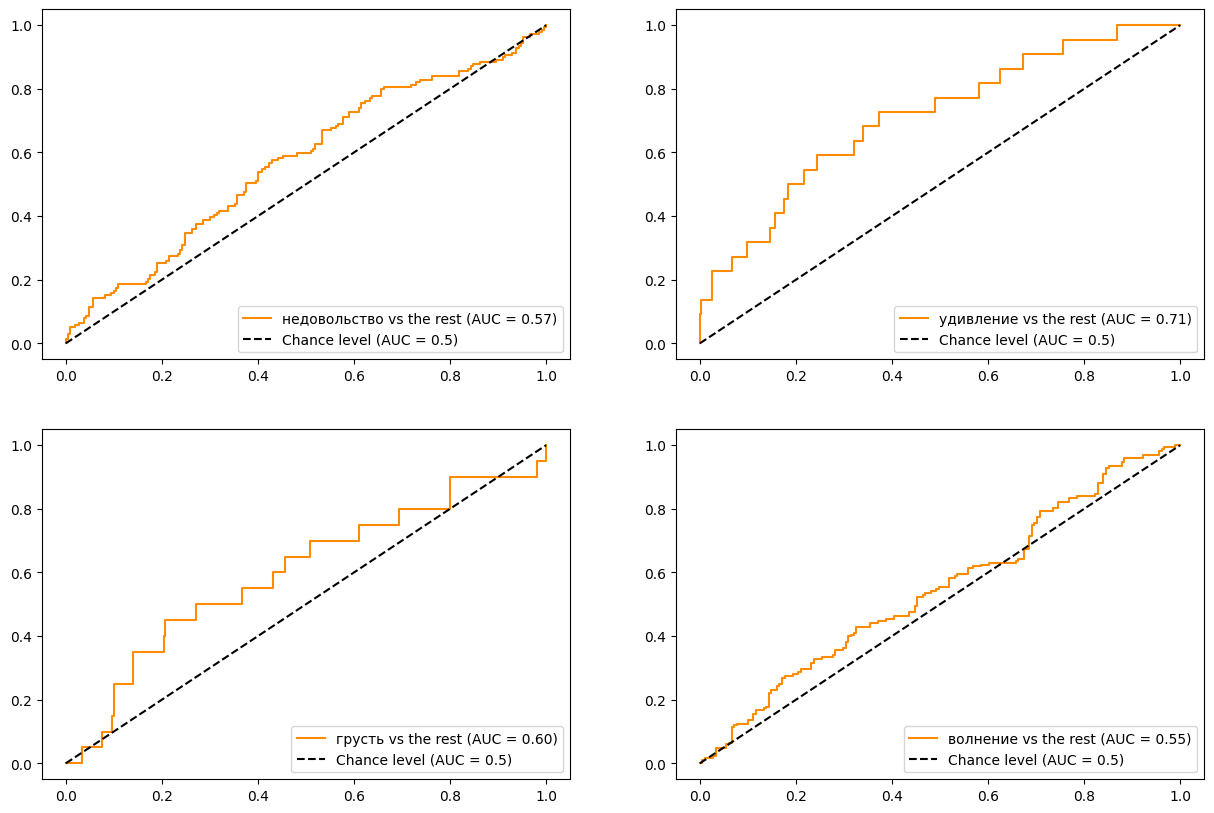

In [ ]:
show_roc_curves(y_train, y_test, y_score=rfc.predict_proba(X_test), classes=rfc.classes_)

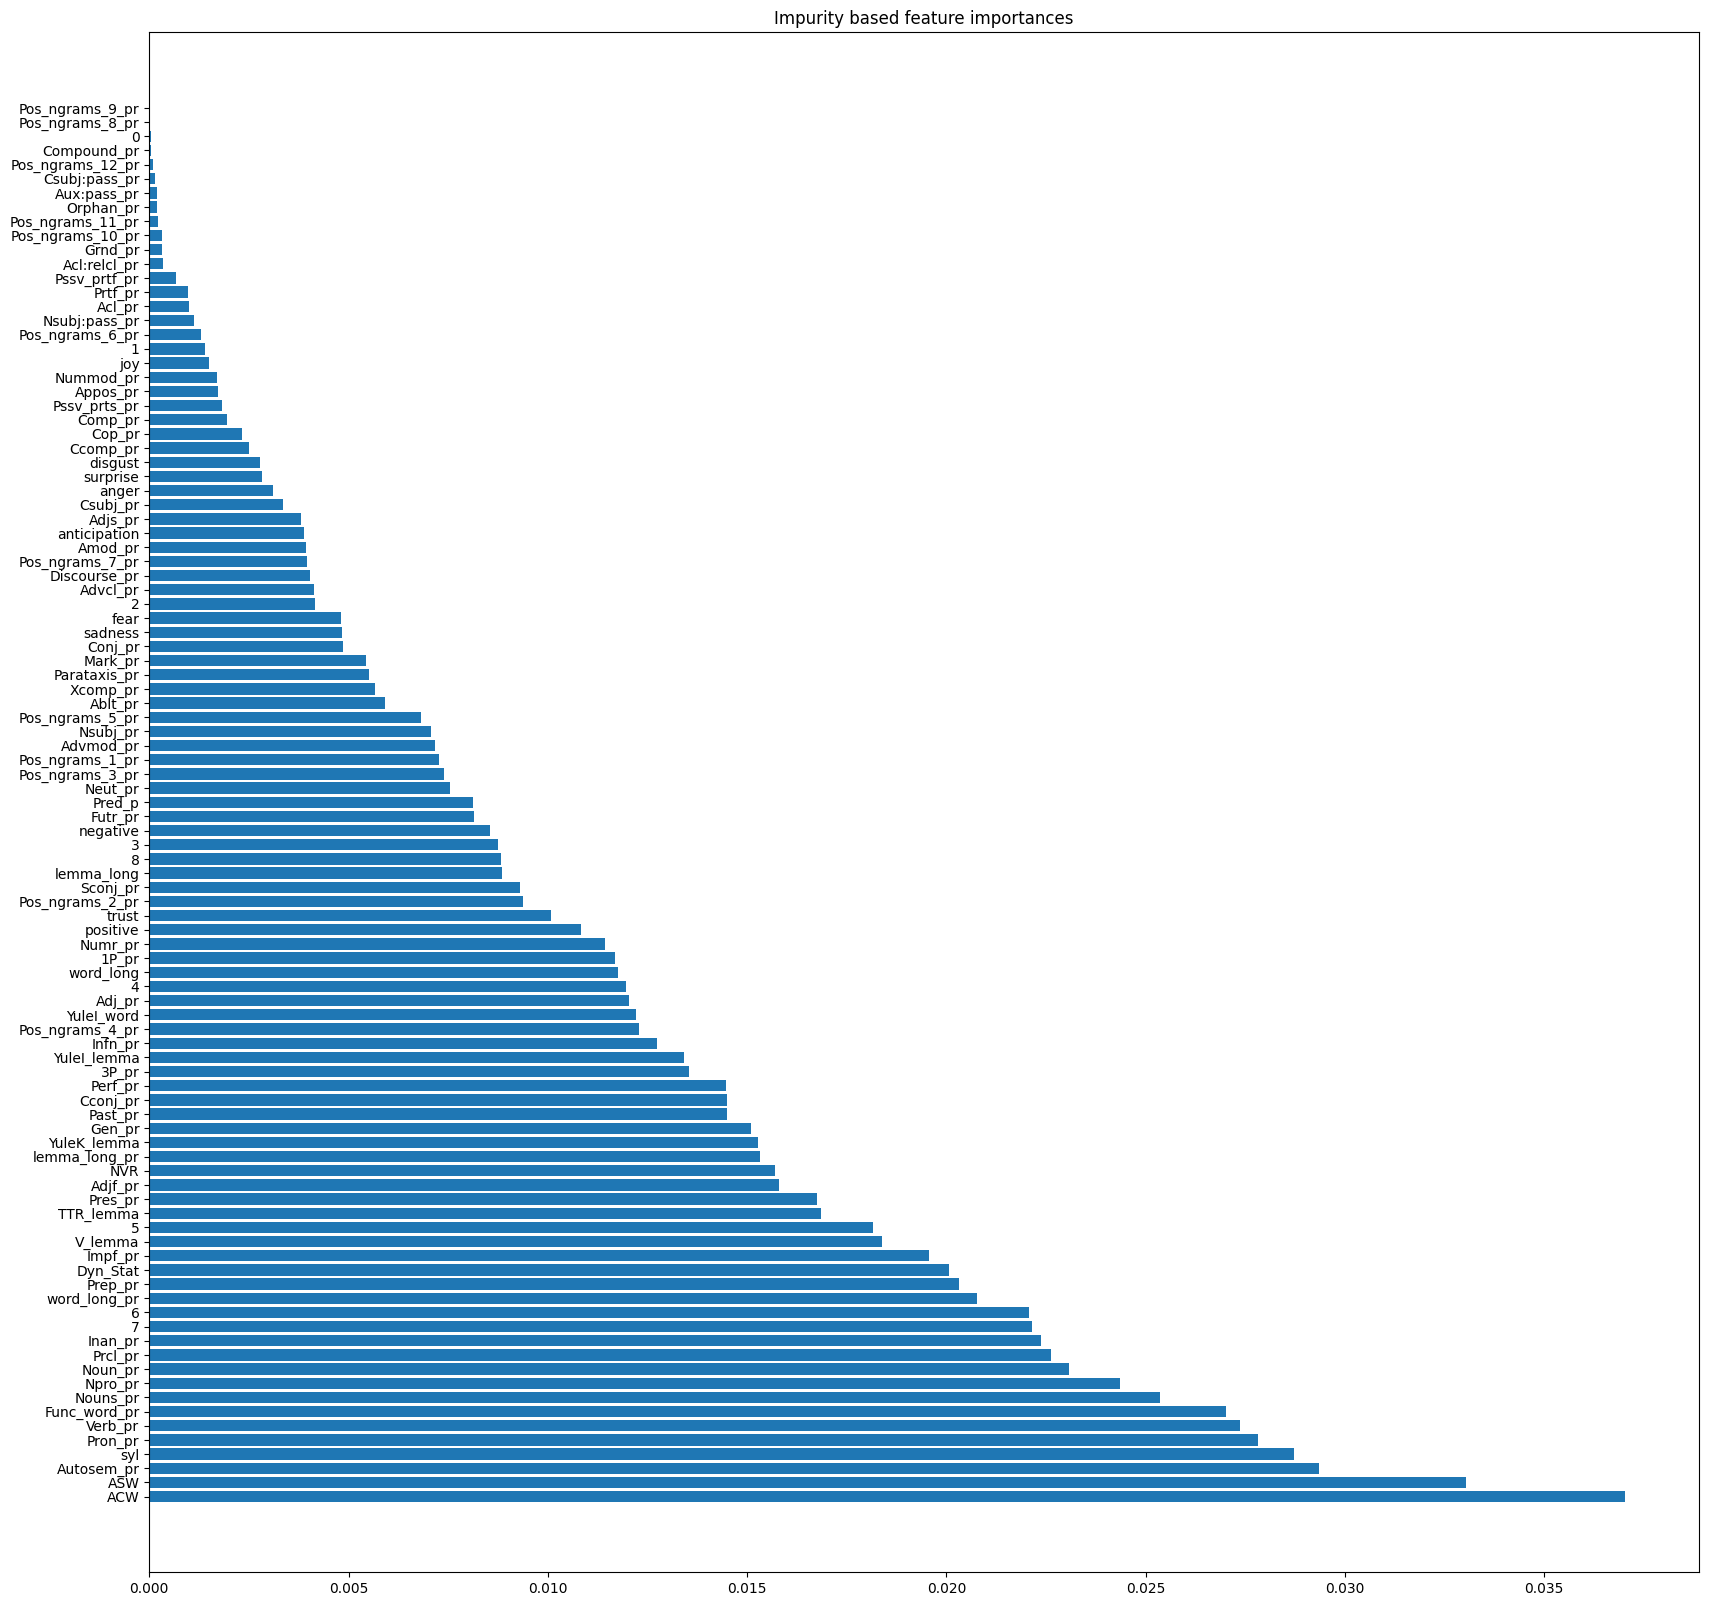

In [ ]:
show_feature_importances(rfc.feature_importances_, X_test.columns, "Impurity based feature importances", size=(20,20))

In [ ]:
perm_imp_rfc = permutation_importance(rfc, X_train, y_train, n_repeats=5, n_jobs=-1, random_state=42)

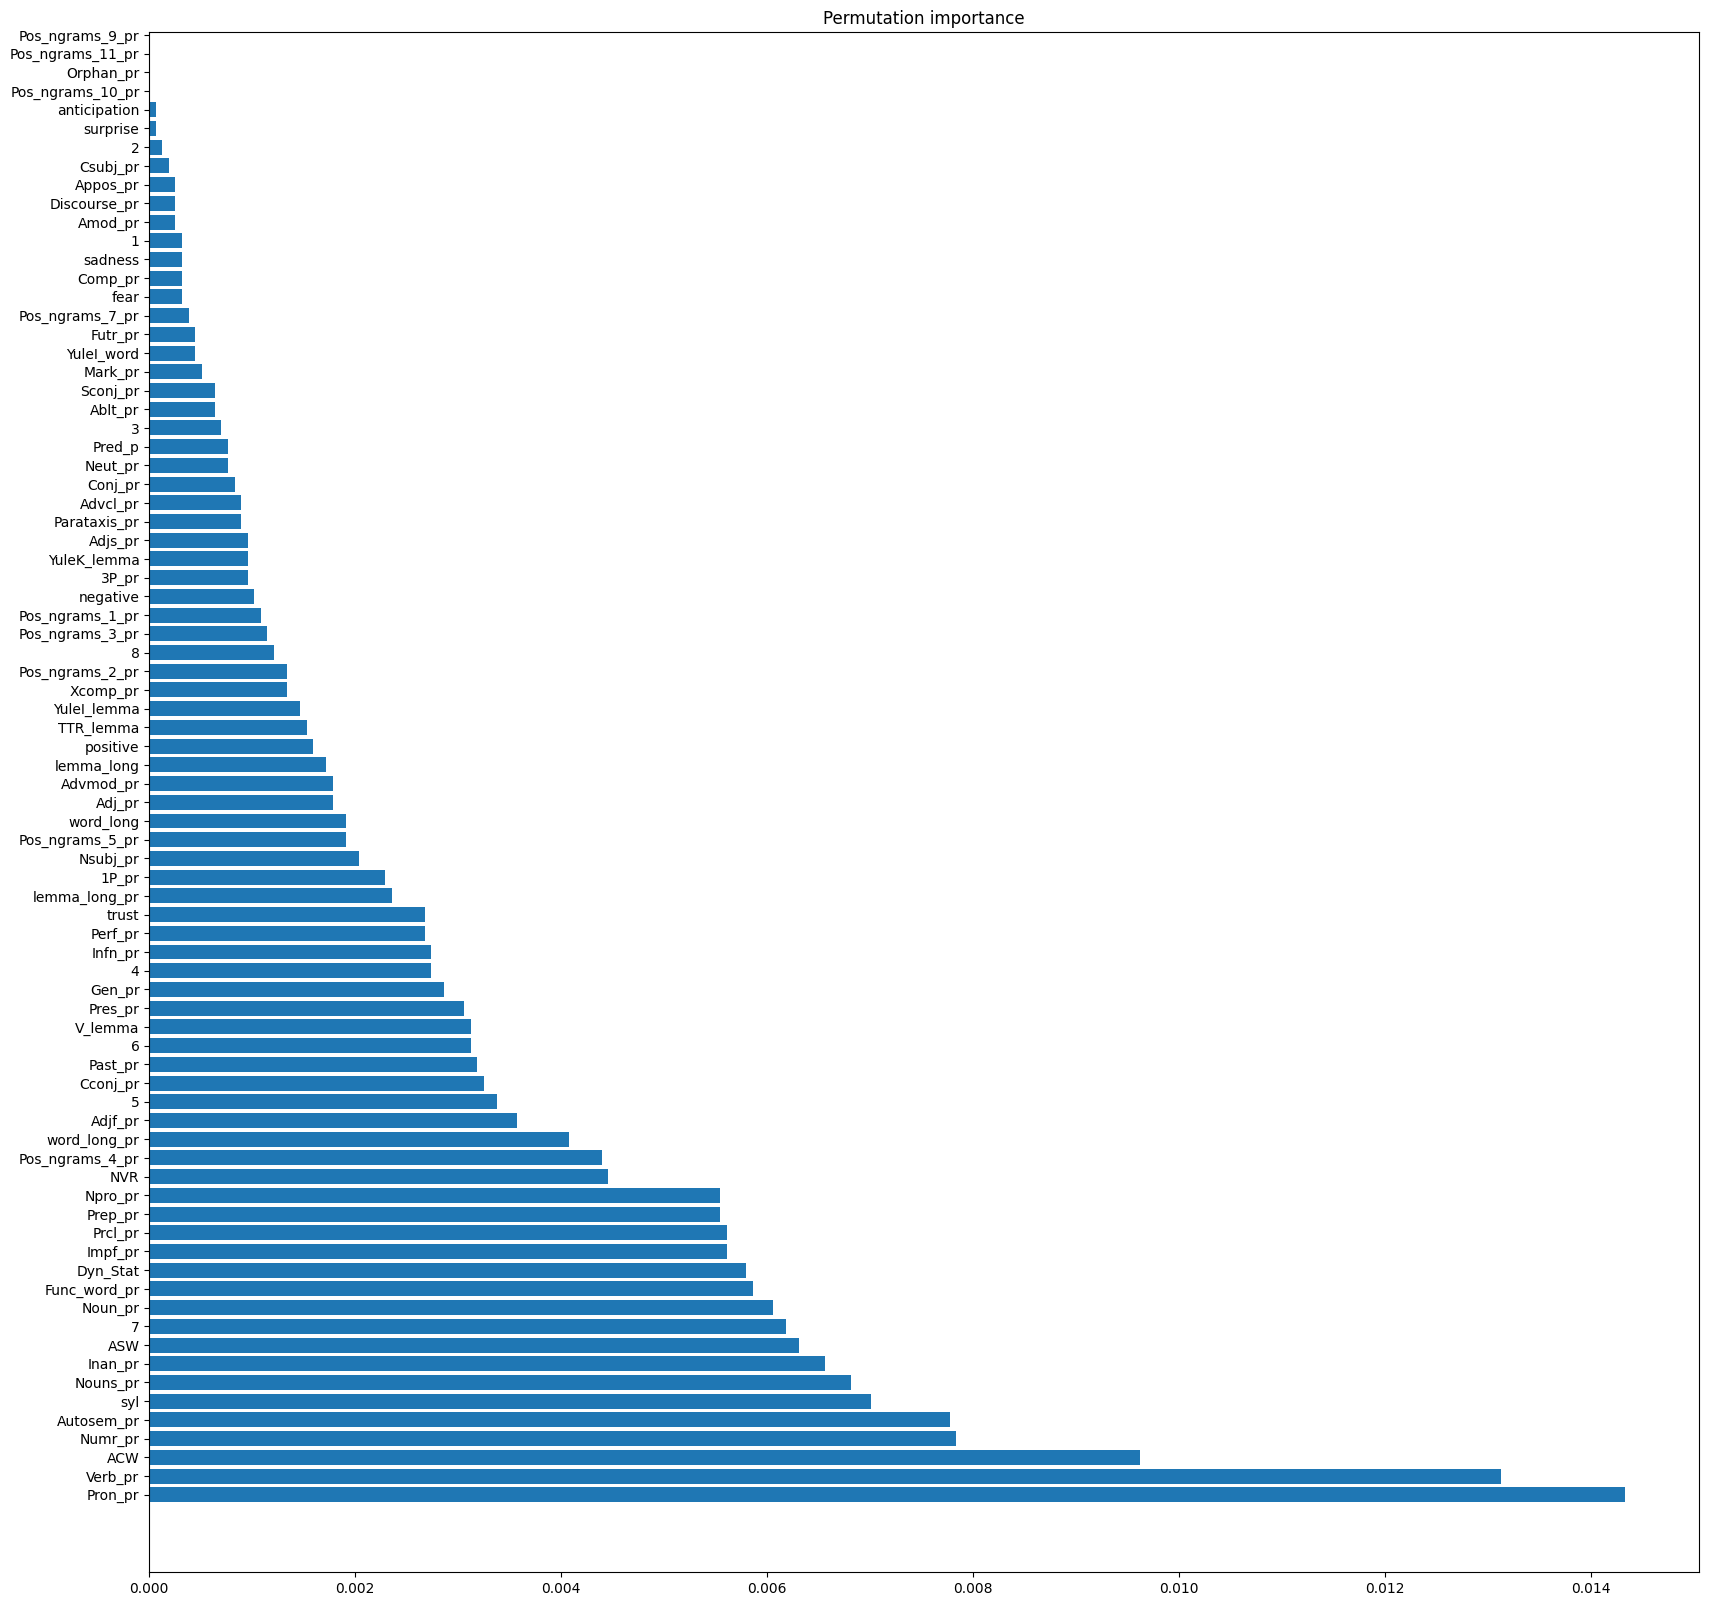

In [ ]:
show_feature_importances(perm_imp_rfc.importances_mean, X_test.columns, "Permutation importance", size=(20,20))

## CatBoost

In [37]:
cbc = CatBoostClassifier()

cbc.fit(X_train, y_train)
preds_class = cbc.predict(X_test)
print_metrics(preds_class, y_test, cbc.predict_proba(X_test))

Learning rate set to 0.08388
0:	learn: 1.3377426	total: 176ms	remaining: 2m 55s
1:	learn: 1.2970710	total: 193ms	remaining: 1m 36s
2:	learn: 1.2618426	total: 212ms	remaining: 1m 10s
3:	learn: 1.2314932	total: 228ms	remaining: 56.7s
4:	learn: 1.2048159	total: 243ms	remaining: 48.3s
5:	learn: 1.1821538	total: 320ms	remaining: 53s
6:	learn: 1.1617347	total: 373ms	remaining: 52.9s
7:	learn: 1.1451048	total: 392ms	remaining: 48.6s
8:	learn: 1.1297987	total: 416ms	remaining: 45.9s
9:	learn: 1.1156955	total: 439ms	remaining: 43.5s
10:	learn: 1.1033668	total: 459ms	remaining: 41.2s
11:	learn: 1.0922407	total: 480ms	remaining: 39.5s
12:	learn: 1.0817165	total: 498ms	remaining: 37.8s
13:	learn: 1.0714021	total: 519ms	remaining: 36.5s
14:	learn: 1.0638024	total: 538ms	remaining: 35.3s
15:	learn: 1.0557135	total: 554ms	remaining: 34.1s
16:	learn: 1.0497690	total: 571ms	remaining: 33s
17:	learn: 1.0431445	total: 590ms	remaining: 32.2s
18:	learn: 1.0376379	total: 605ms	remaining: 31.2s
19:	learn: 1.

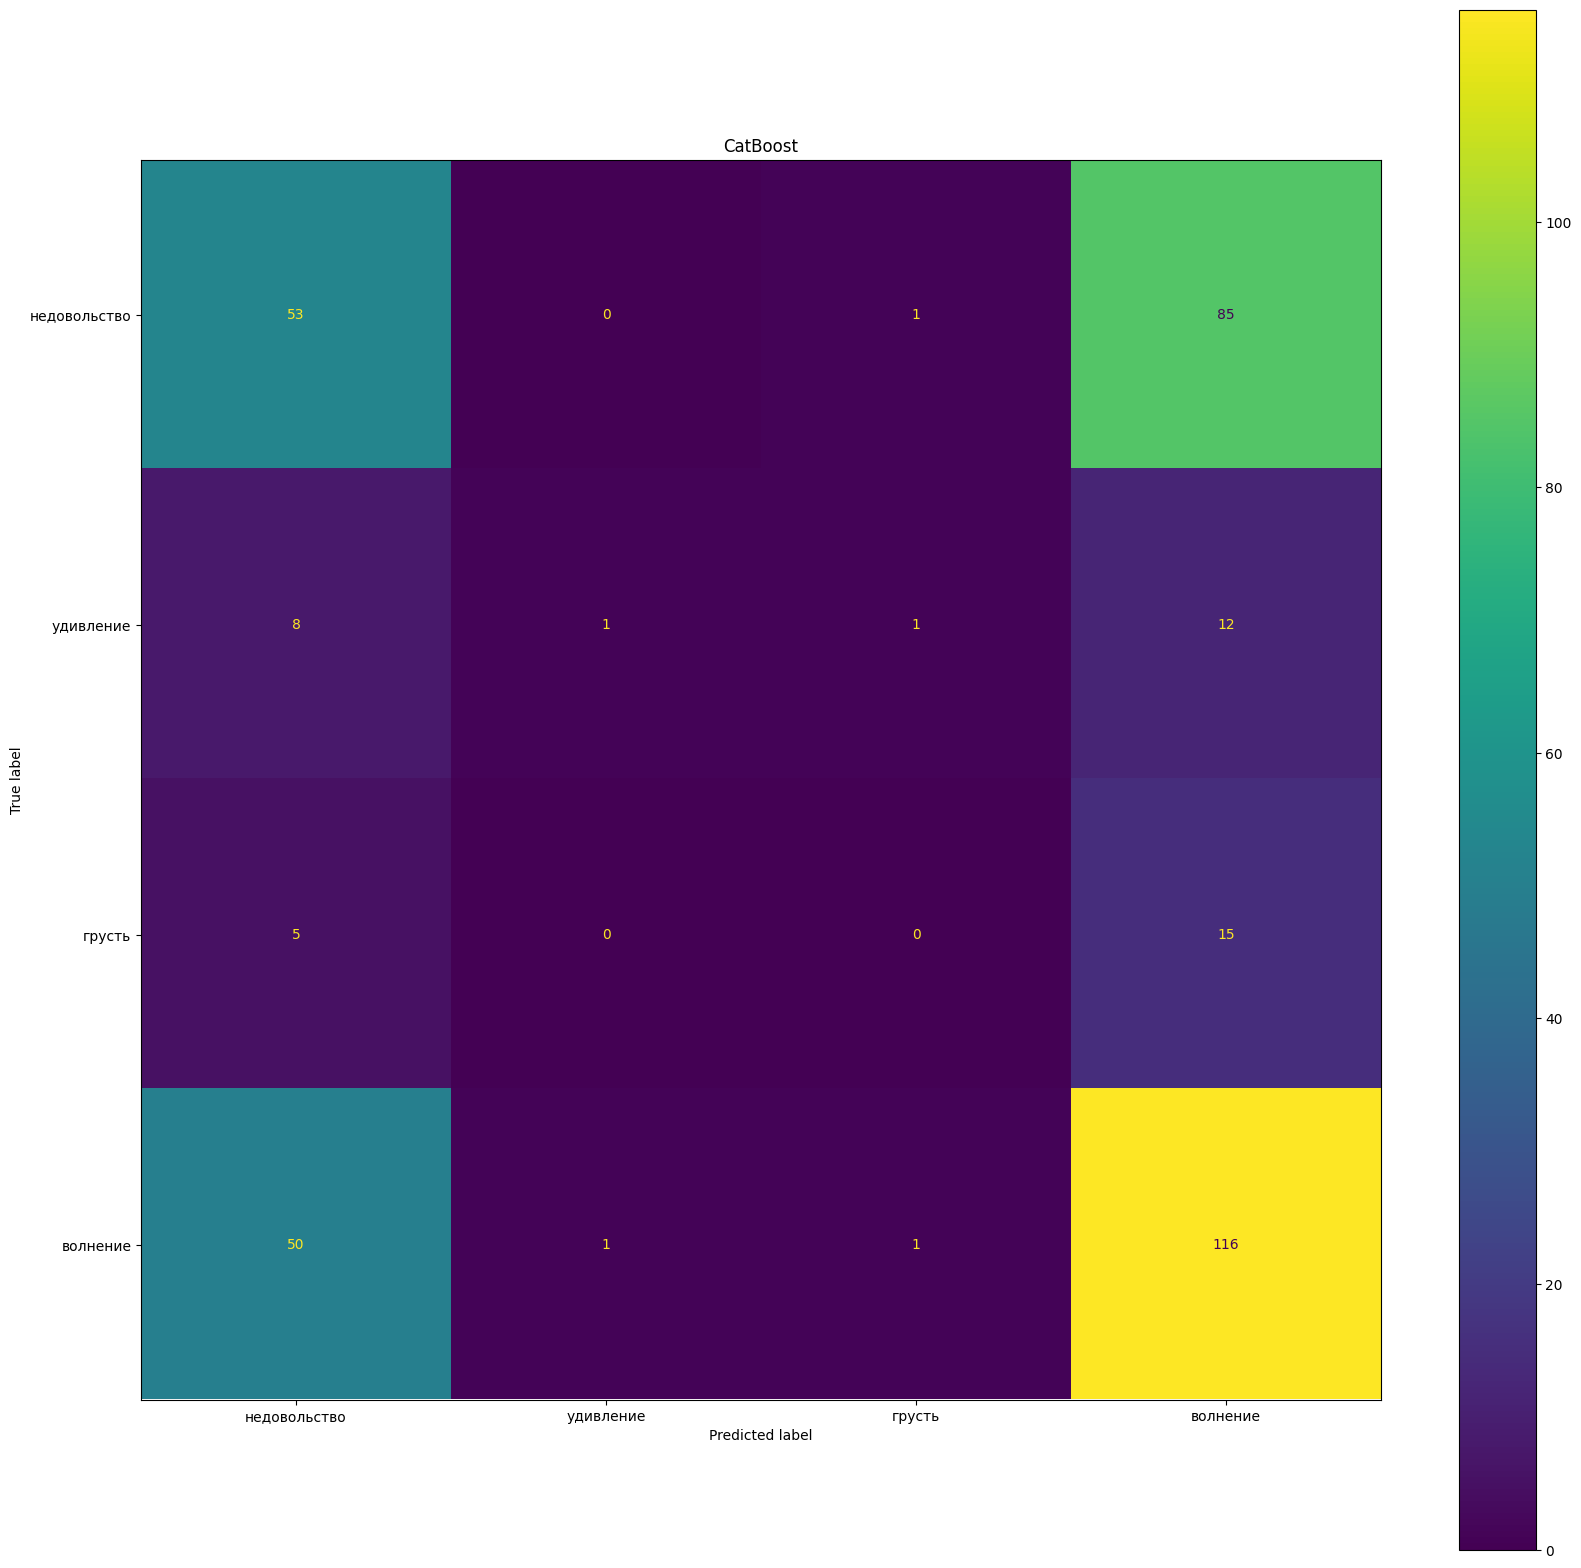

In [38]:
show_conf_matrx(y_test, cbc.predict(X_test), cbc.classes_, "CatBoost")

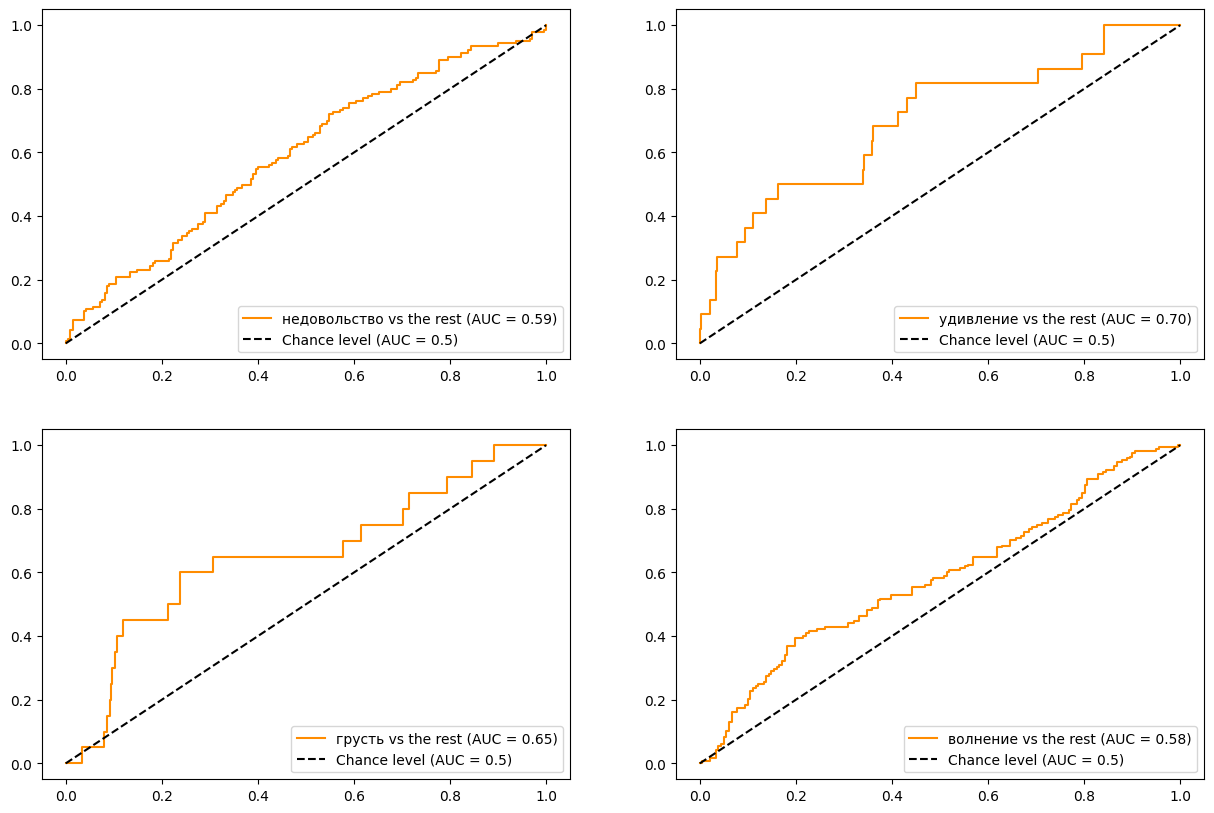

In [39]:
show_roc_curves(y_train, y_test, cbc.predict_proba(X_test), classes=cbc.classes_)

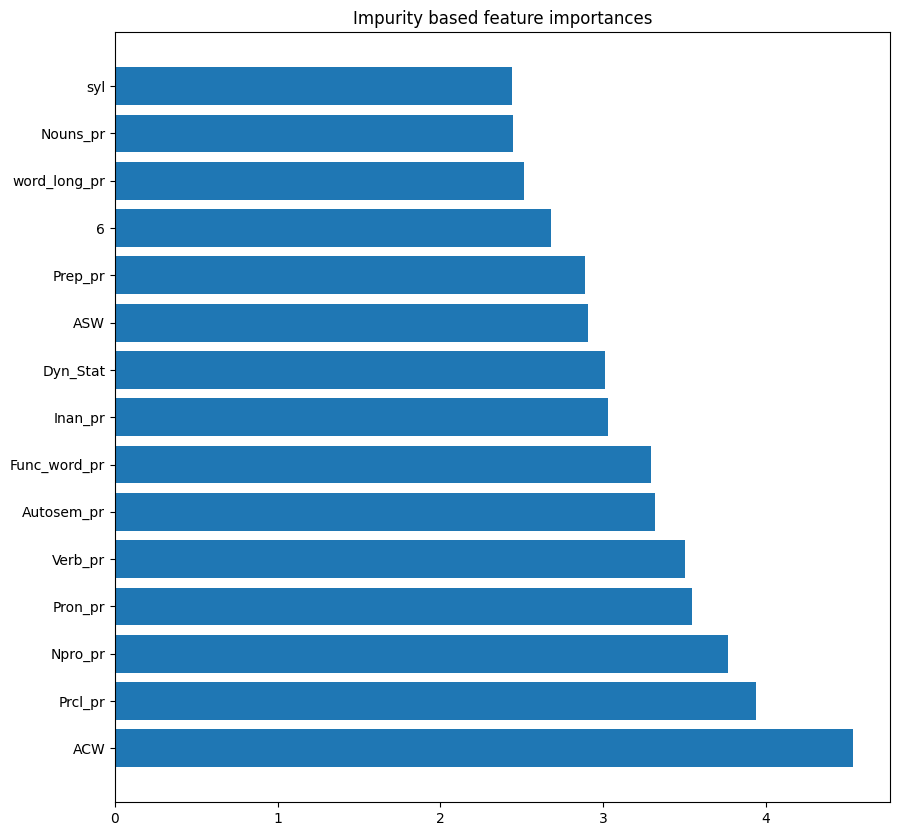

In [48]:
show_feature_importances(cbc.feature_importances_, X_test.columns, "Impurity based feature importances", size=(10,10))

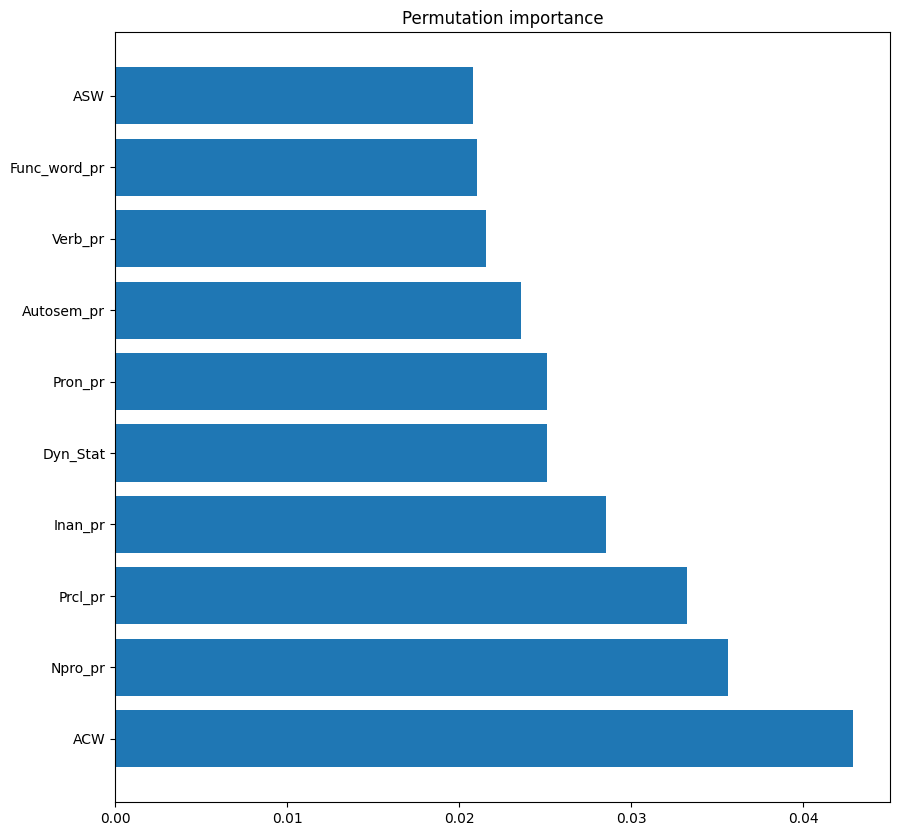

In [52]:
perm_imp_cbc = permutation_importance(cbc, X_train, y_train, n_repeats=5, n_jobs=-1, random_state=42)
show_feature_importances(perm_imp_cbc.importances_mean, X_test.columns, "Permutation importance", size=(10,10))

## Gaussian Naive Bayes

In [57]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)#.predict(X_test)

print_metrics(gnb.predict(X_test), y_test, gnb.predict_proba(X_test))

MSE: 12.701149425287356
Accuracy: 0.08045977011494253
F-score: 0.050208085612366234
ROC-AUC: 0.5444406065435687


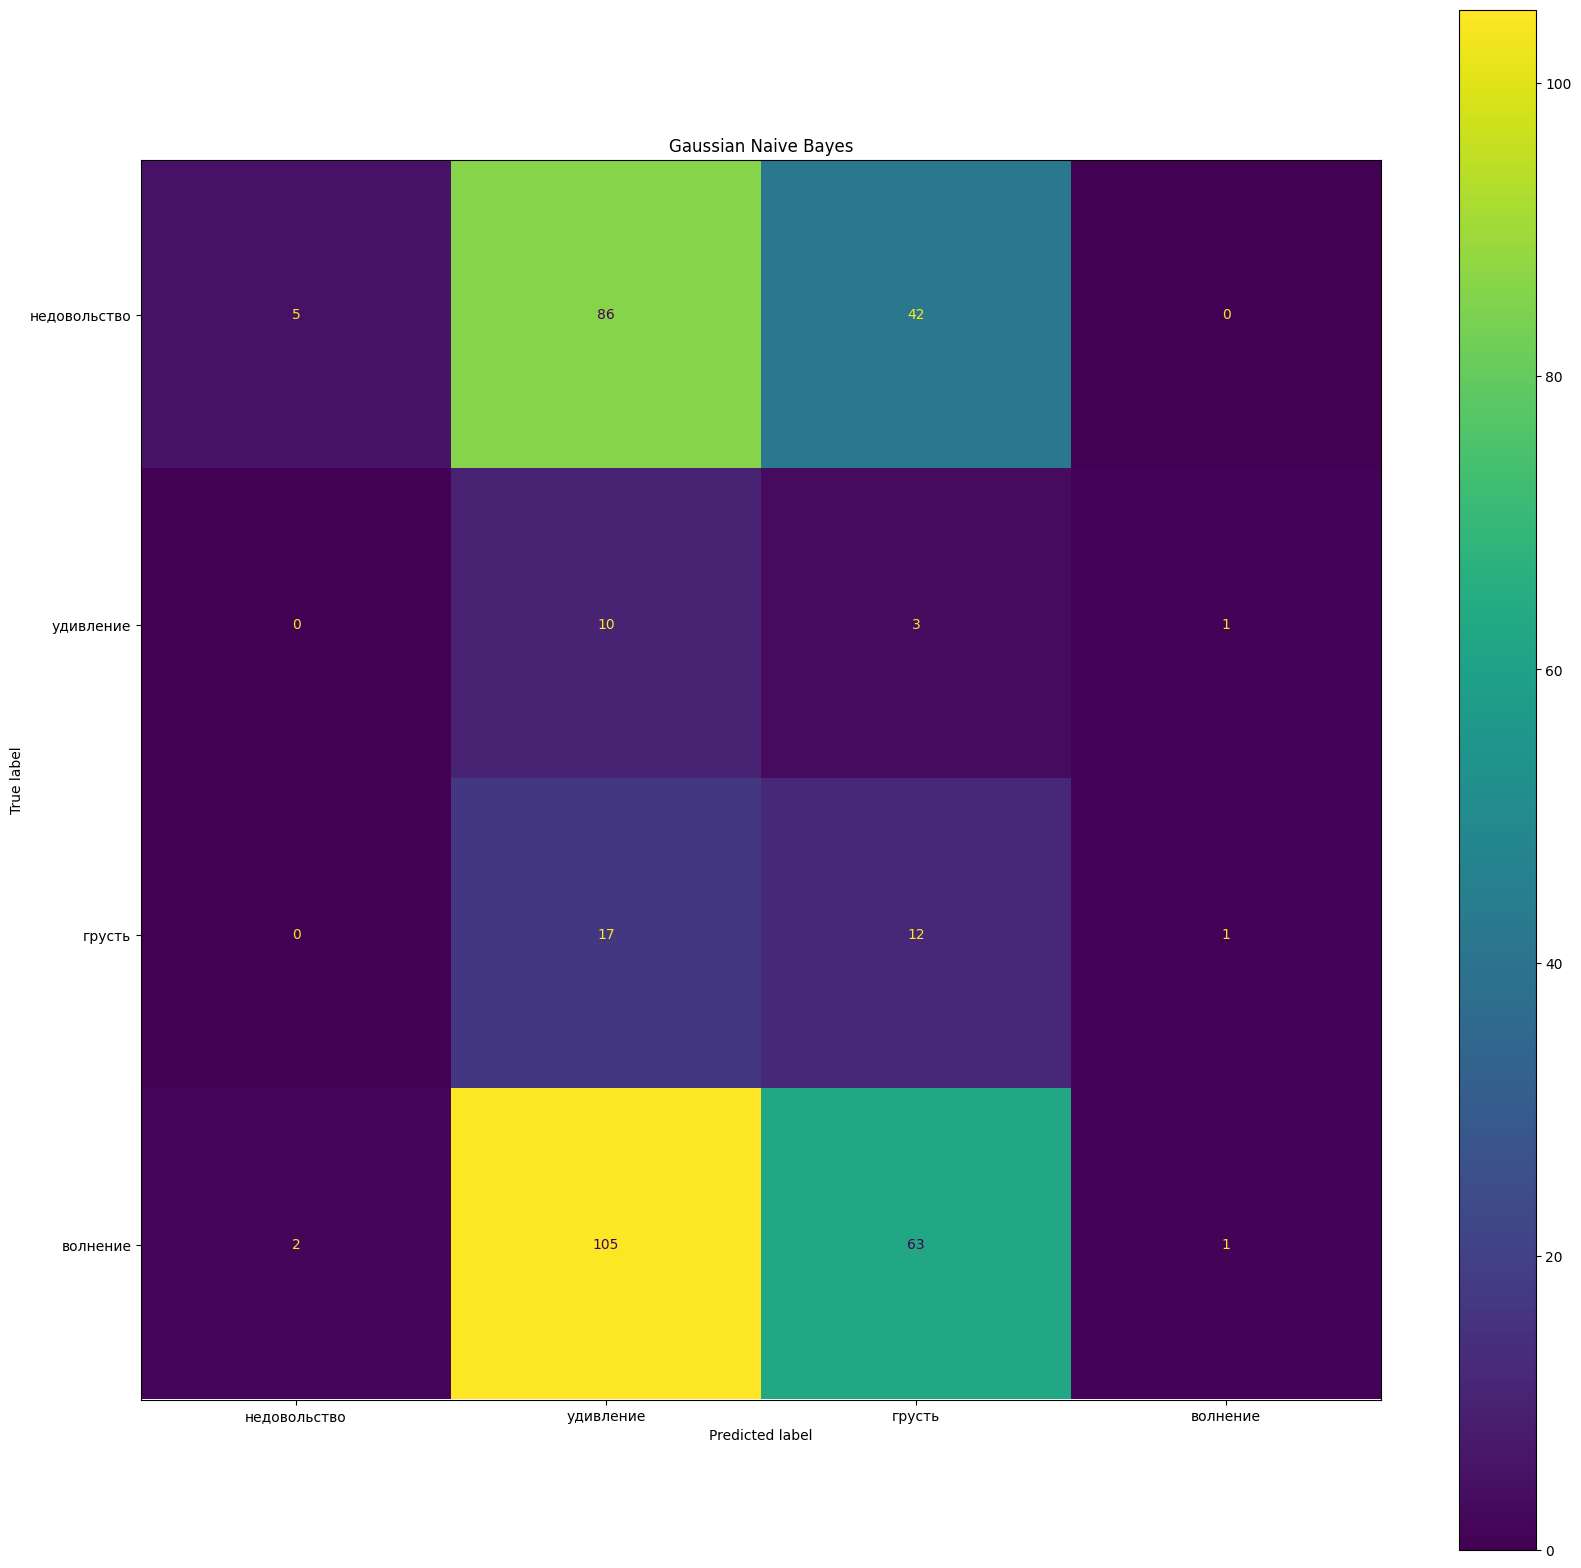

In [58]:
show_conf_matrx(y_test, gnb.predict(X_test), gnb.classes_, "Gaussian Naive Bayes")

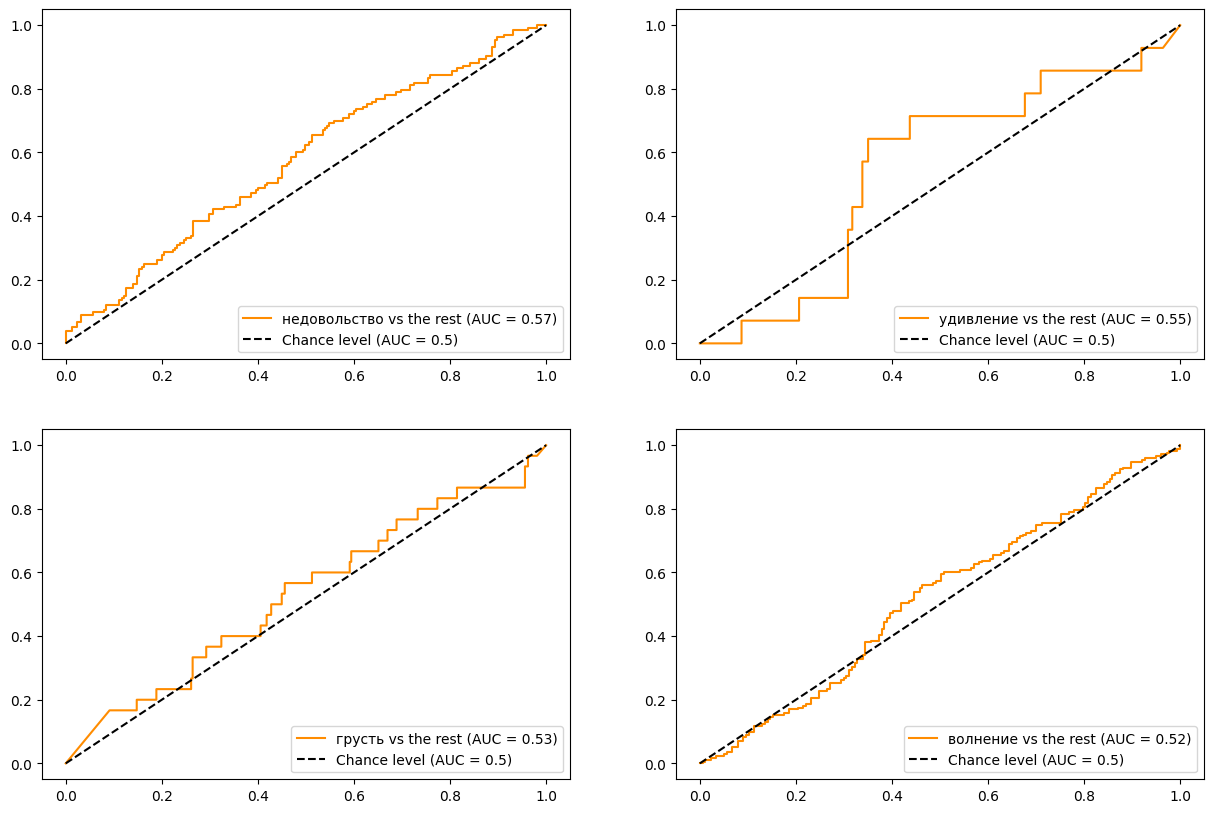

In [59]:
show_roc_curves(y_train, y_test, gnb.predict_proba(X_test), classes=gnb.classes_)

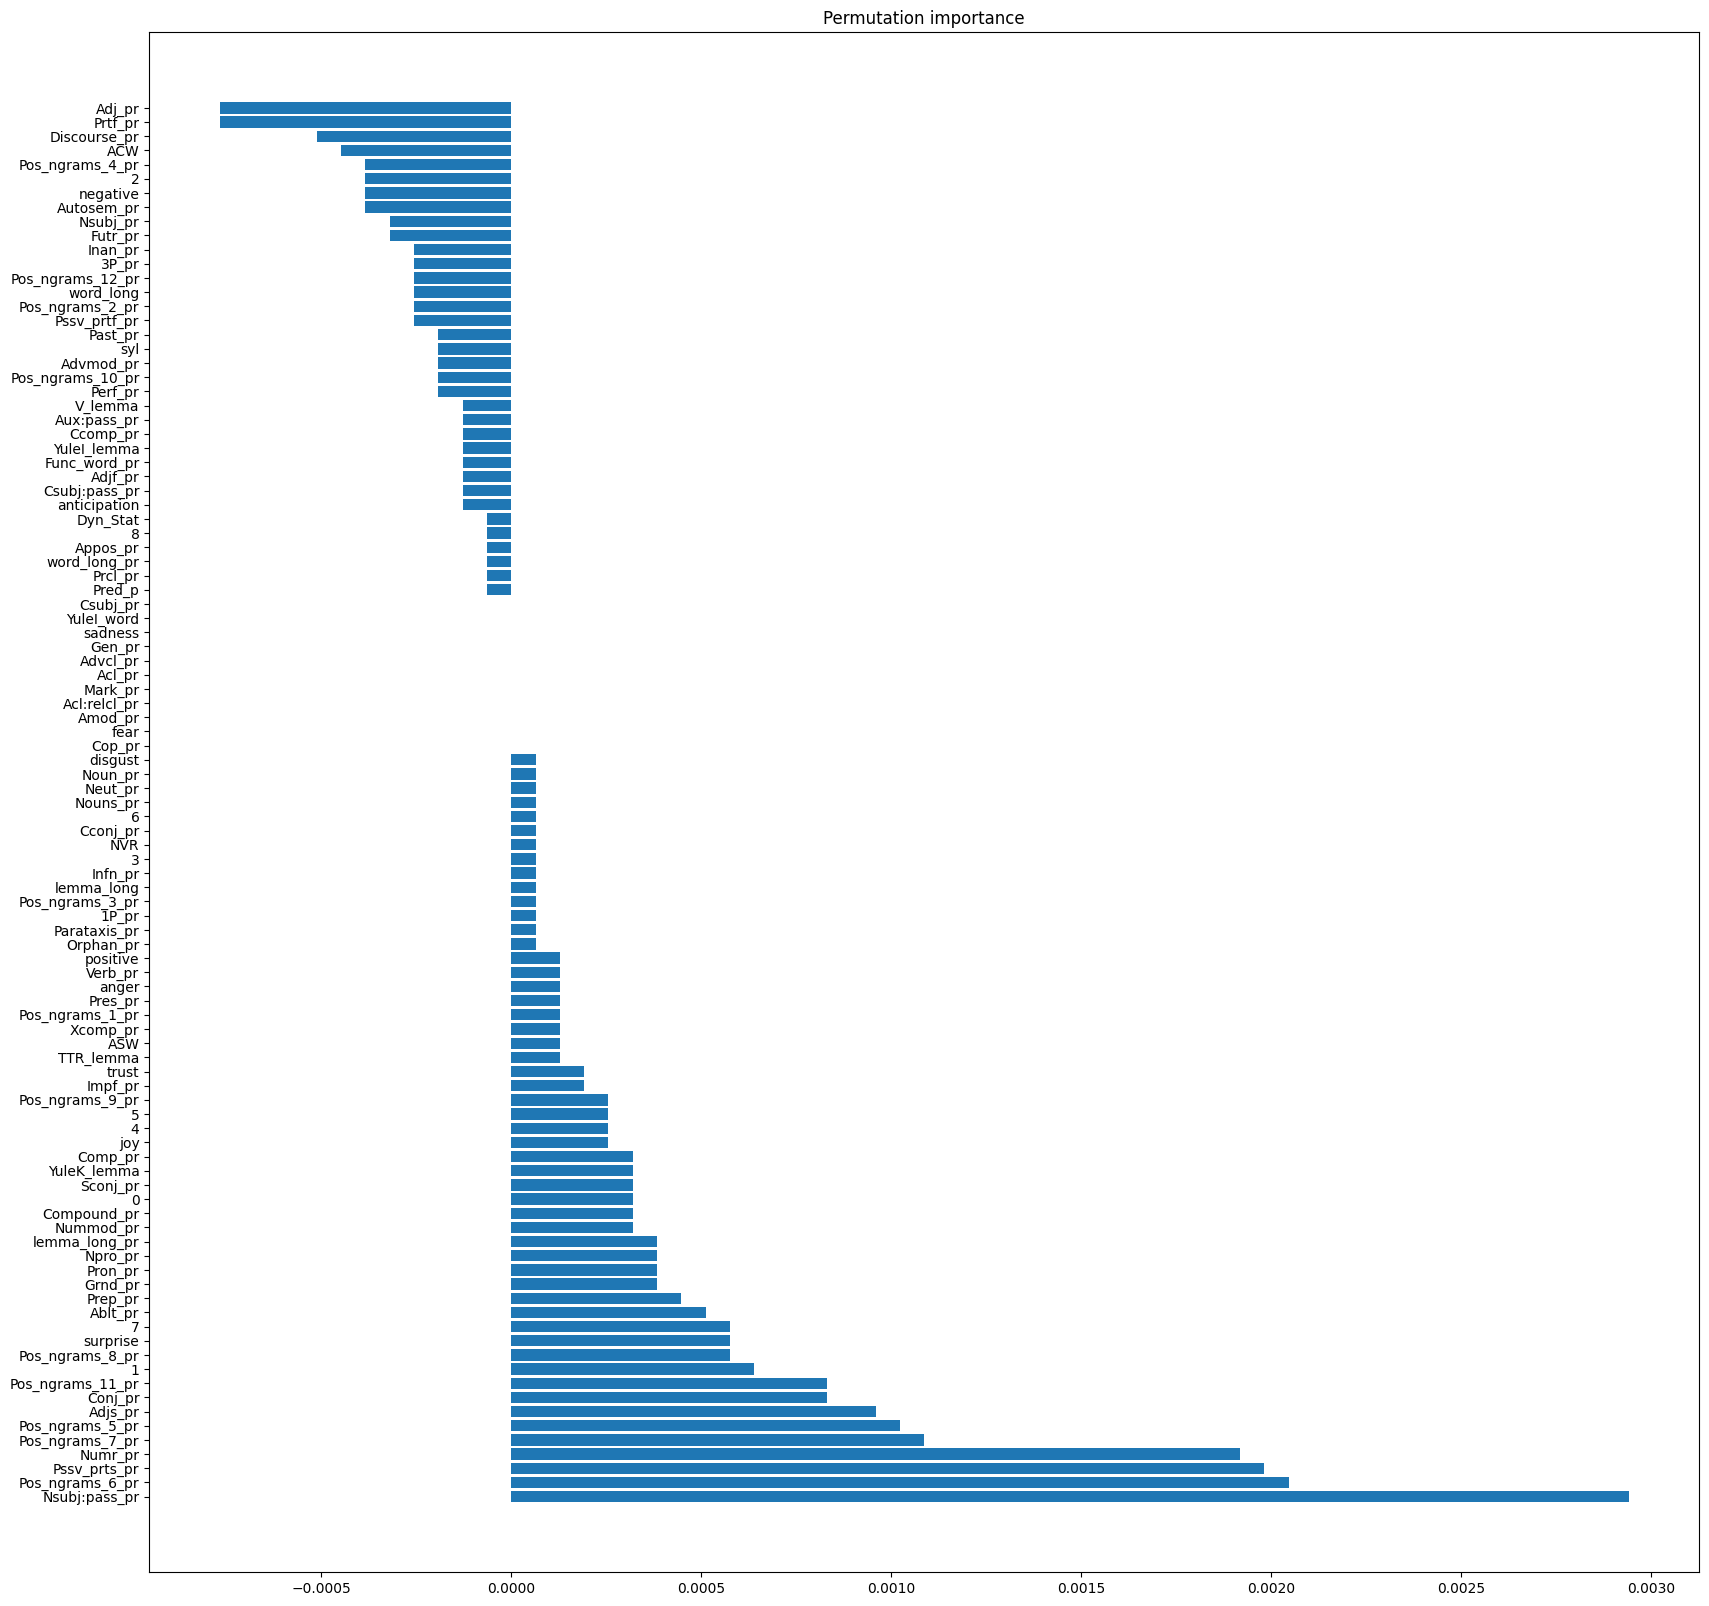

In [60]:
perm_imp_gnb = permutation_importance(gnb, X_train, y_train, n_repeats=5, n_jobs=-1, random_state=42)
show_feature_importances(perm_imp_gnb.importances_mean, X_test.columns, "Permutation importance", size=(20,20))

## K Nearest Neighbors

In [54]:
knc = KNeighborsClassifier()

knc.fit(X=X_train, y=y_train)

print_metrics(knc.predict(X_test), y_test, knc.predict_proba(X_test))

MSE: 19.272988505747126
Accuracy: 0.47413793103448276
F-score: 0.46020510862261377
ROC-AUC: 0.546713024614288


## Ridge (Linear classifiers) 

In [55]:
ridge = RidgeClassifier()

ridge.fit(X=X_train, y=y_train)

print_metrics(ridge.predict(X=X_test), y=y_test)

MSE: 18.135057471264368
Accuracy: 0.5402298850574713
F-score: 0.48856159266512283


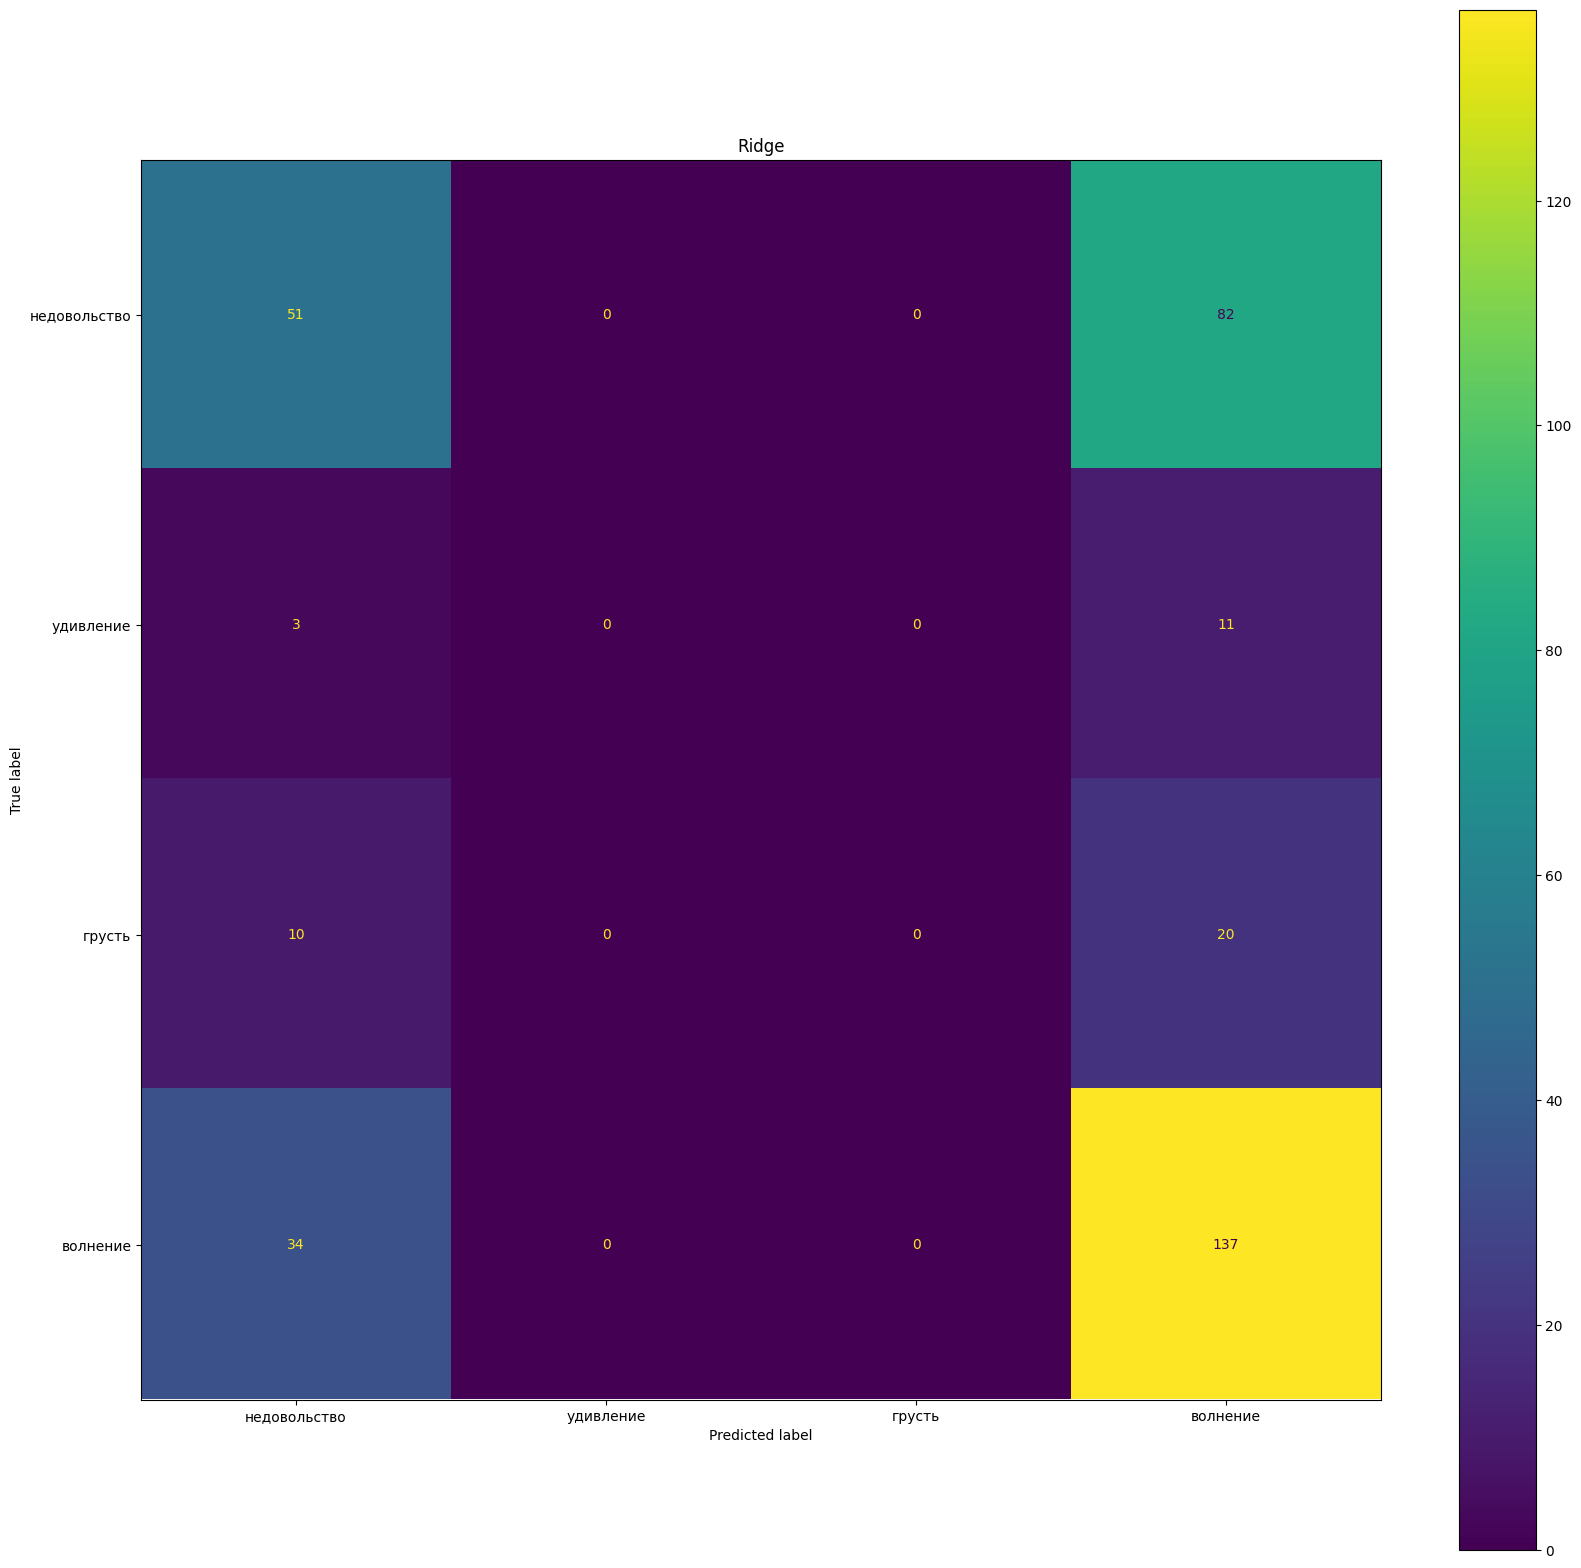

In [56]:
show_conf_matrx(y_test, ridge.predict(X_test), ridge.classes_, "Ridge")

## Gaussian Process

In [26]:
gpc = GaussianProcessClassifier(kernel=(1.0 * RBF(1.0)),
                                optimizer="fmin_l_bfgs_b",
                                n_restarts_optimizer=0,
                                max_iter_predict=100,
                                warm_start=False,
                                copy_X_train=True,
                                random_state=42,
                                multi_class="one_vs_rest", # "one_vs_one",
                                n_jobs=-1)
gpc.fit(X=X_train, y=y_train)

print_metrics(gpc.predict(X_test), y_test, gpc.predict_proba(X_test))

MSE: 21.06590257879656
Accuracy: 0.4899713467048711
F-score: 0.39687083635104403
ROC-AUC: 0.5901524909004877


## Support Vecs

In [61]:
linSVM = SVC(kernel="linear", C=0.025, random_state=42, probability=True)
rbfSVM = SVC(gamma=2, C=1, random_state=42, probability=True)

In [62]:
rbfSVM.fit(X=X_train, y=y_train)

print("Test:")
print_metrics(rbfSVM.predict(X_test), y_test, rbfSVM.predict_proba(X_test))
print("\nTrain:")
print_metrics(rbfSVM.predict(X_train), y_train, rbfSVM.predict_proba(X_train))

Test:
MSE: 20.227011494252874
Accuracy: 0.49712643678160917
F-score: 0.33637565843484163
ROC-AUC: 0.5118250255189071

Train:
MSE: 0.0
Accuracy: 1.0
F-score: 1.0
ROC-AUC: 0.5846575569554303


In [63]:
linSVM.fit(X=X_train, y=y_train)

print("Test:")
print_metrics(linSVM.predict(X_test), y_test, linSVM.predict_proba(X_test))
print("\nTrain:")
print_metrics(linSVM.predict(X_train), y_train, linSVM.predict_proba(X_train))

Test:
MSE: 18.25574712643678
Accuracy: 0.5373563218390804
F-score: 0.48296189487014163
ROC-AUC: 0.580521201428926

Train:
MSE: 16.843620083146785
Accuracy: 0.5701950751519028
F-score: 0.519181246113585
ROC-AUC: 0.68643475712968


In [64]:
svm = SVC(random_state = 42, 
          C=2,
          probability=True)
svm.fit(X=X_train, y=y_train)

print("Test:")
print_metrics(svm.predict(X_test), y_test, svm.predict_proba(X_test))
print("\nTrain:")
print_metrics(svm.predict(X_train), y_train, svm.predict_proba(X_train))

Test:
MSE: 17.899425287356323
Accuracy: 0.5402298850574713
F-score: 0.48926999266324284
ROC-AUC: 0.6060547316274995

Train:
MSE: 6.656859609849696
Accuracy: 0.7966101694915254
F-score: 0.7725084578099836
ROC-AUC: 0.9513015842143256


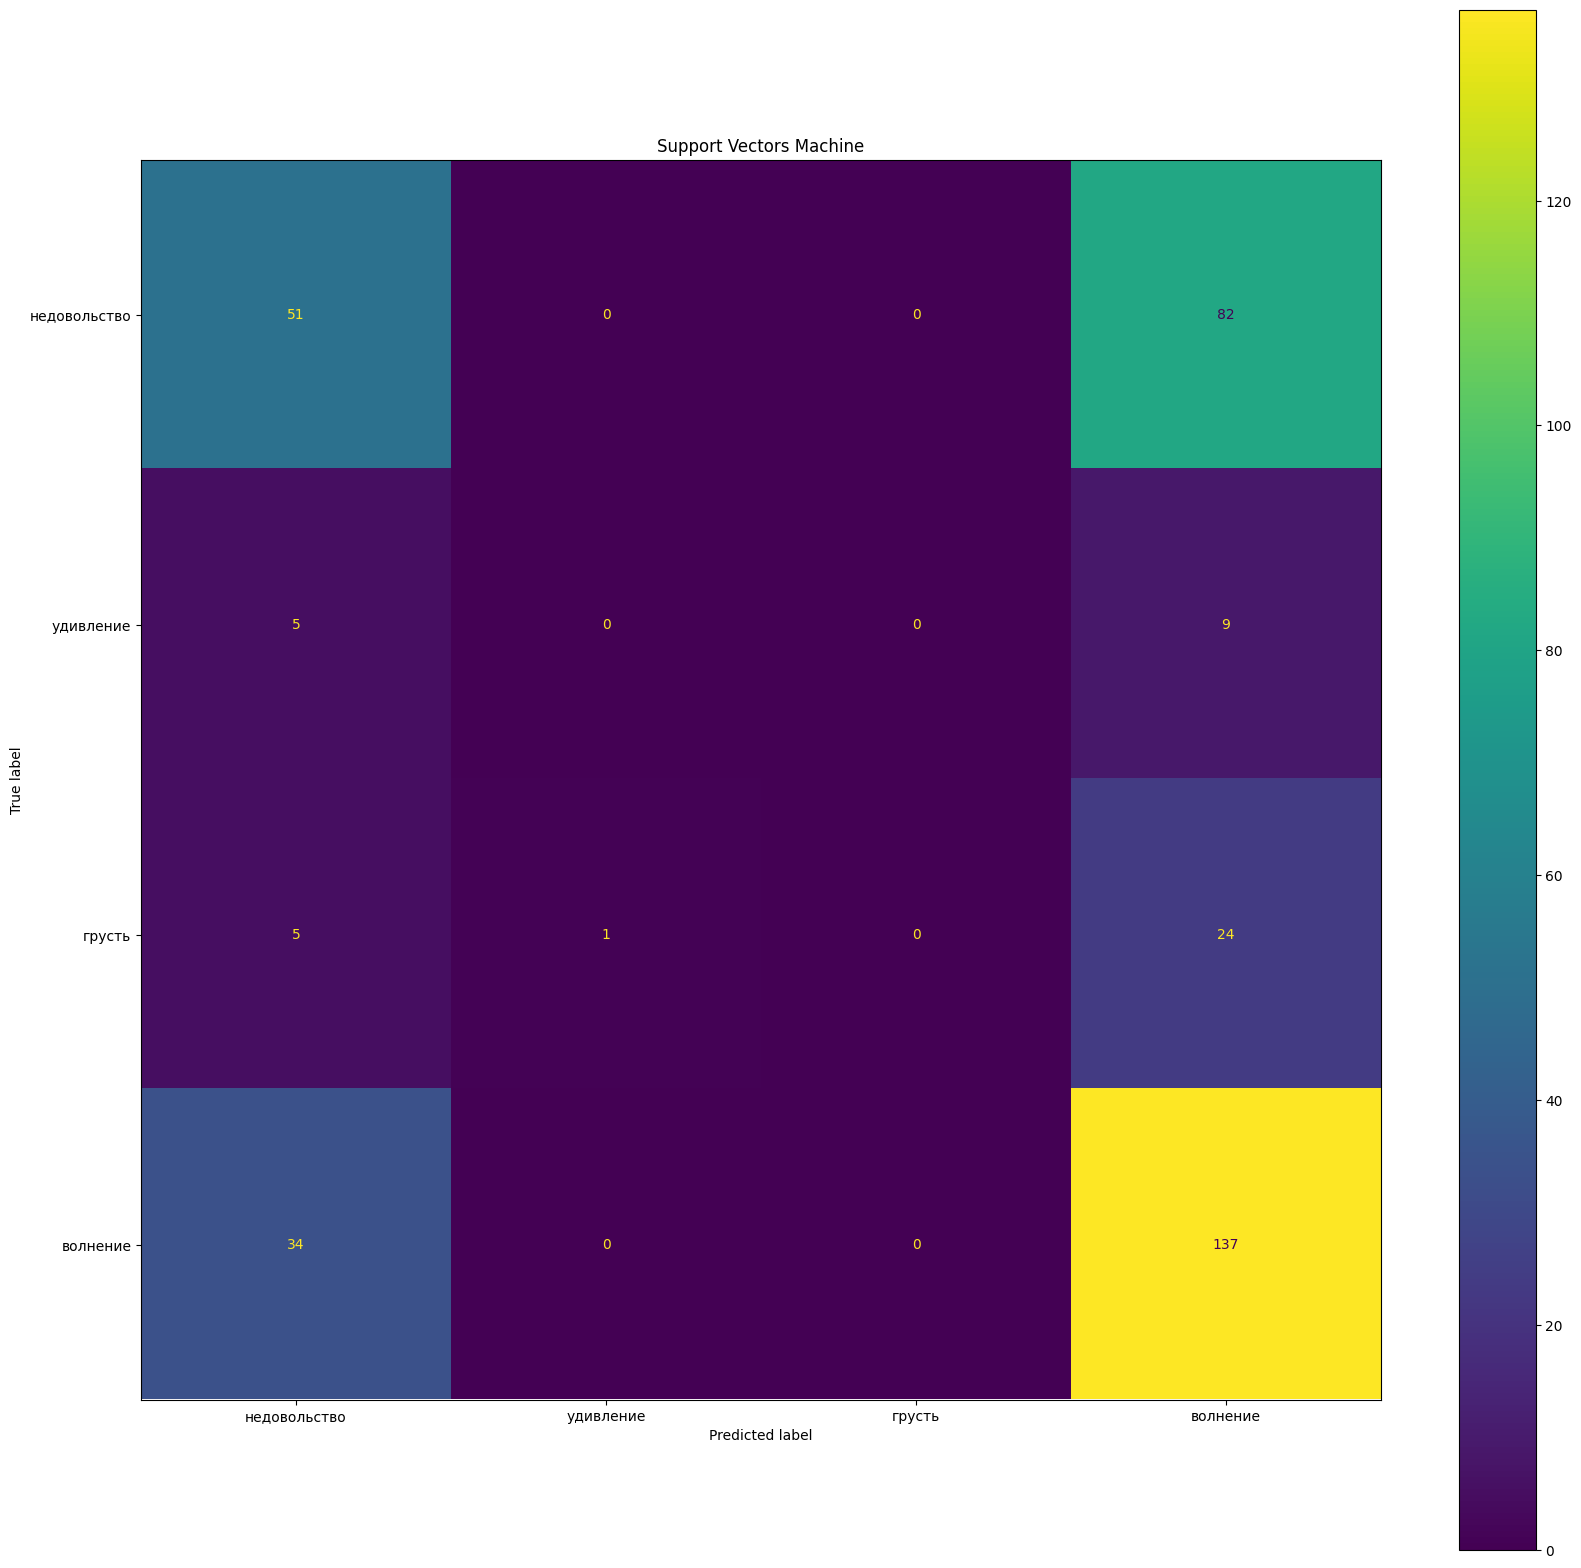

In [65]:
show_conf_matrx(y_test, svm.predict(X_test), svm.classes_, "Support Vectors Machine")

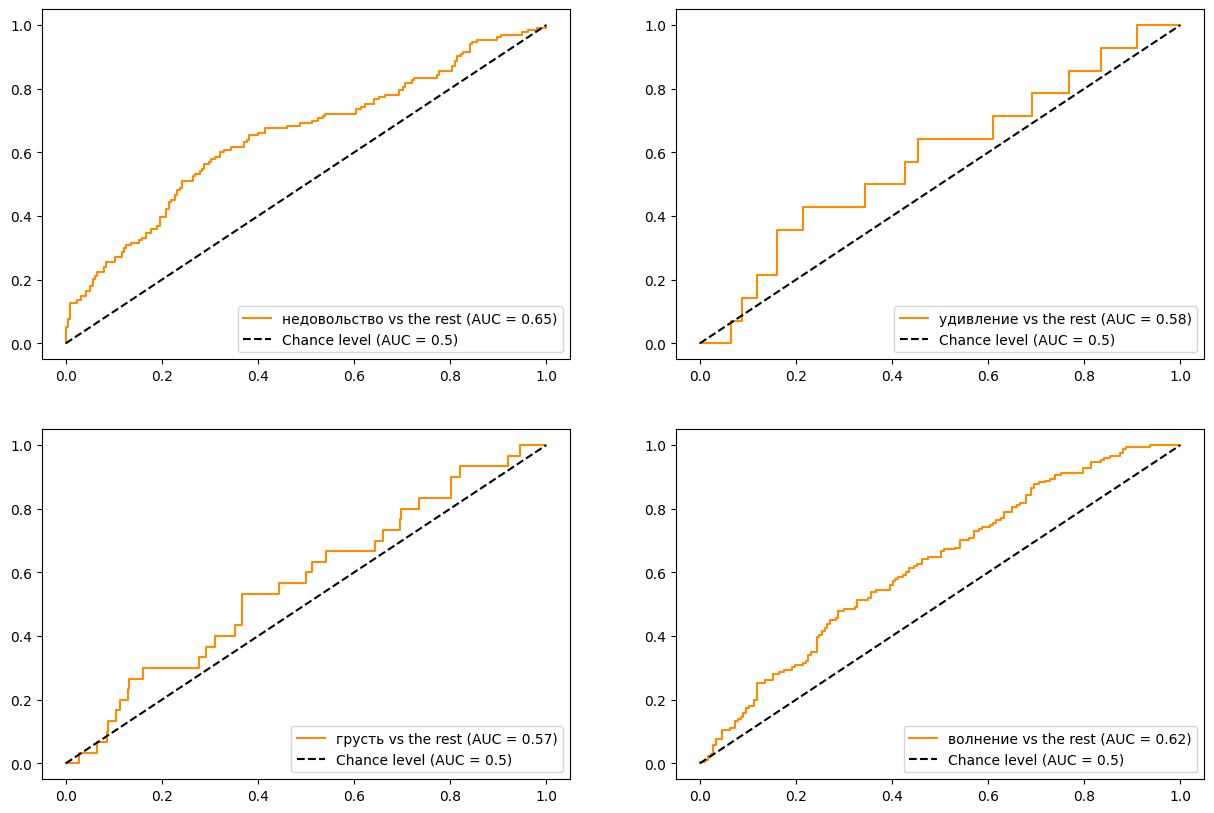

In [66]:
show_roc_curves(y_train, y_test, svm.predict_proba(X_test), svm.classes_)

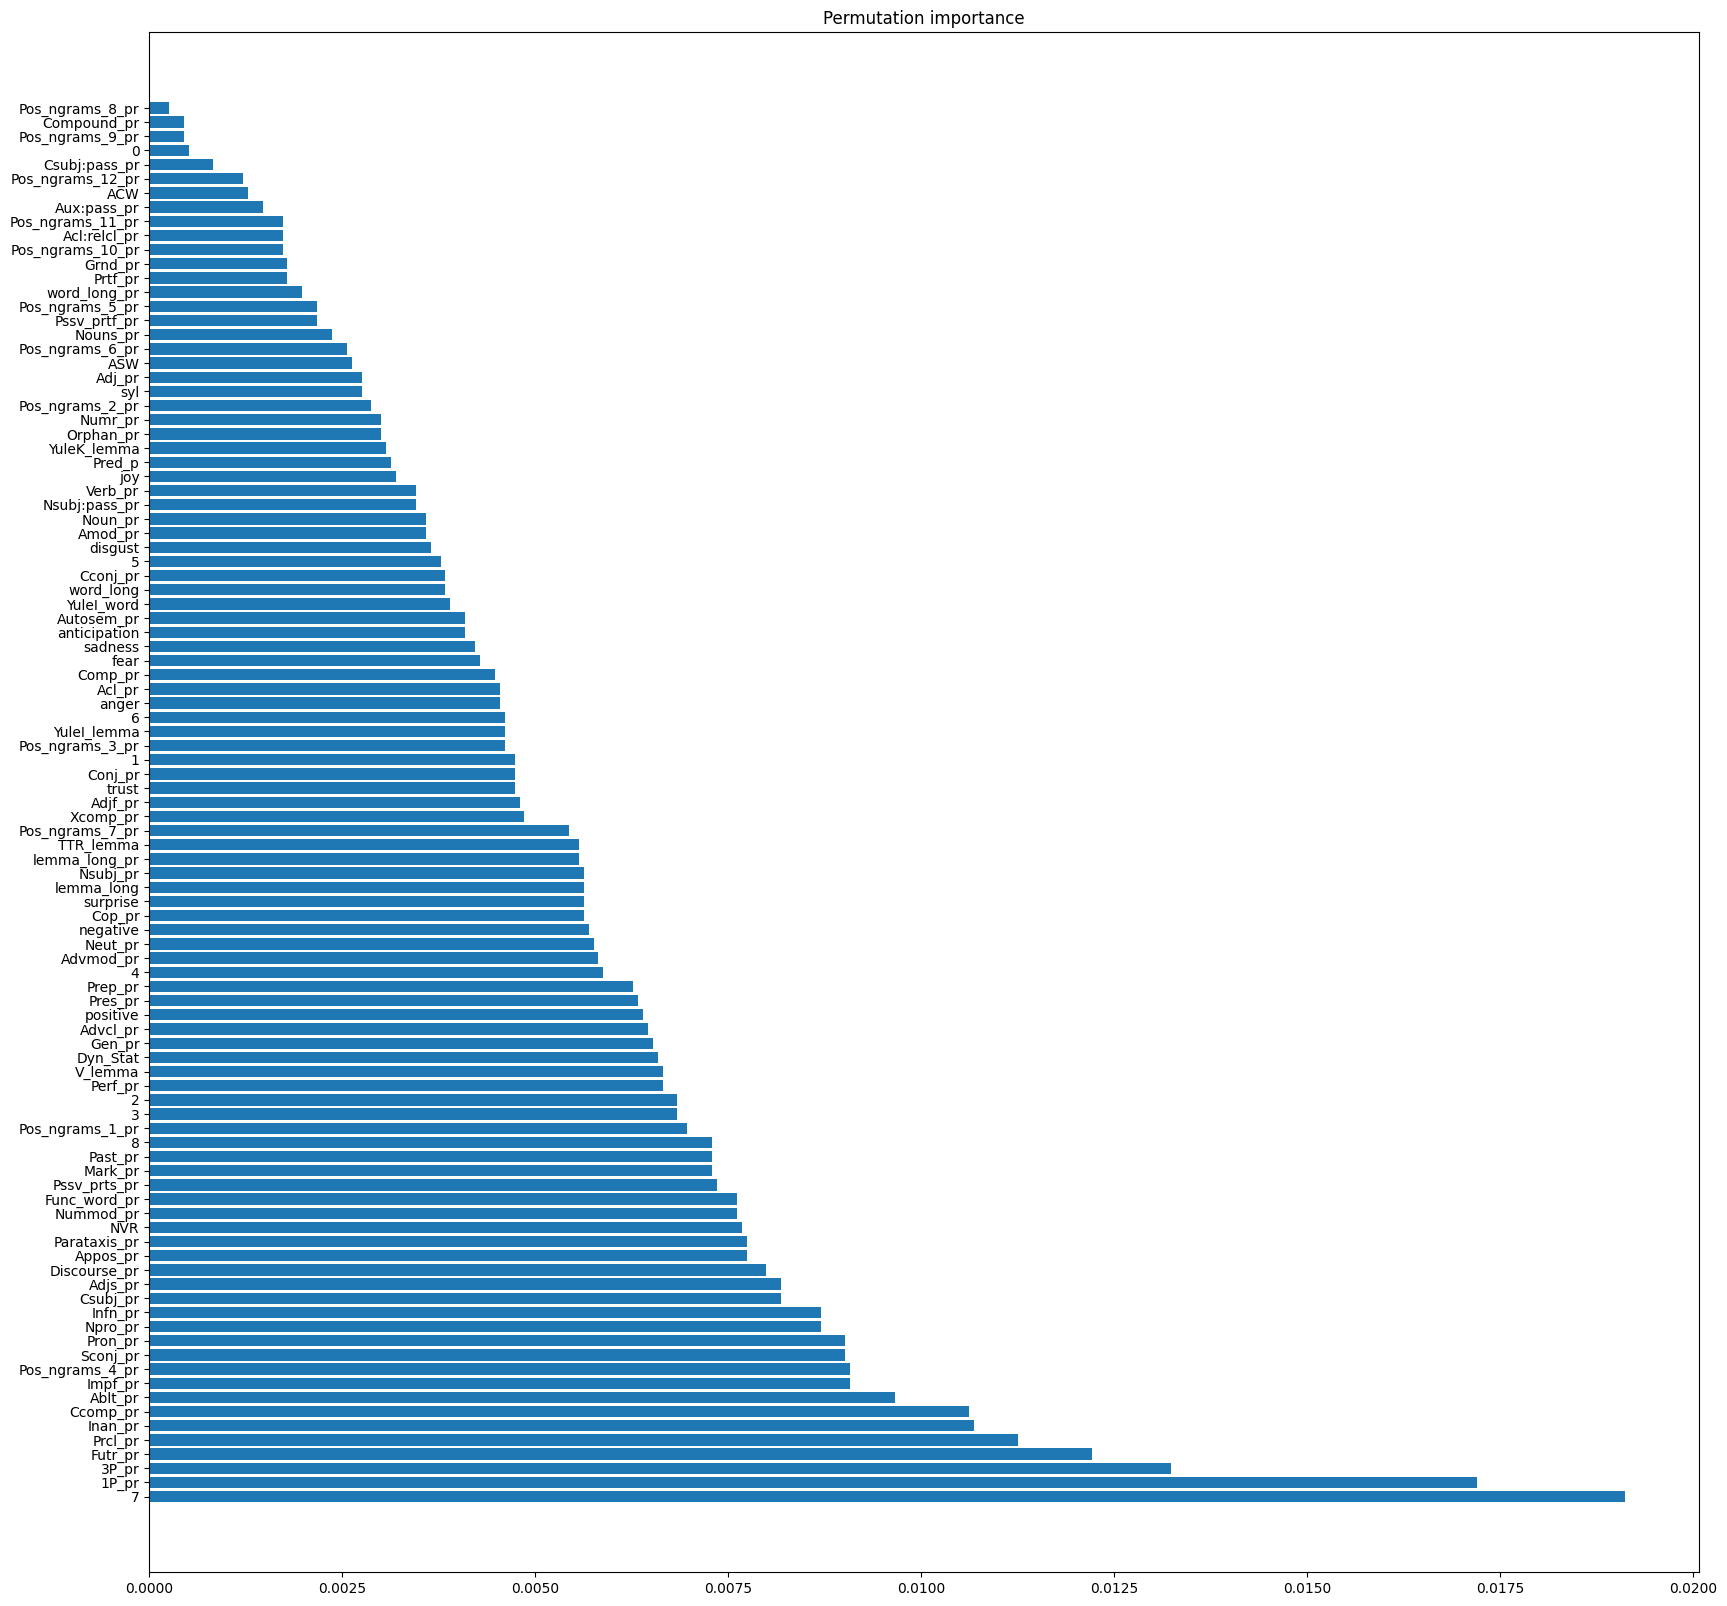

In [67]:
perm_imp_svm = permutation_importance(svm, X_train, y_train, n_repeats=5, n_jobs=-1, random_state=42)
show_feature_importances(perm_imp_svm.importances_mean, X_test.columns, "Permutation importance", size=(20,20))

## AdaBoost

In [68]:
ada = AdaBoostClassifier()
ada.fit(X=X_train, y=y_train)

print("Test:")
print_metrics(ada.predict(X_test), y_test, ada.predict_proba(X_test))
print("\nTrain:")
print_metrics(ada.predict(X_train), y_train, ada.predict_proba(X_train))

Test:
MSE: 19.57758620689655
Accuracy: 0.47988505747126436
F-score: 0.44881597069155105
ROC-AUC: 0.5484423711312003

Train:
MSE: 17.47969299648225
Accuracy: 0.5484489926447074
F-score: 0.5120319918689133
ROC-AUC: 0.671217168742473
